In [68]:
import ROOT
from ROOT import gStyle, TH1F, TCanvas
#conda install -c conda-forge root
#conda install -c conda-forge uproot
# pip install hist
import uproot
import math
from numpy import *
import sys
import os
from os import path
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import multiprocessing as mp
from timeit import default_timer as timer
import pandas as pd
from matplotlib.colors import LogNorm
import matplotlib
from matplotlib import rc
from matplotlib.pyplot import figure

import matplotlib.font_manager
from IPython.core.display import HTML

from scipy.optimize import curve_fit

from matplotlib.patches import Rectangle
from PIL import Image

def make_html(fontname):
    
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

#HTML("<div style='column-count: 2;'>{}</div>".format(code))
# Say, "the default sans-serif font is COMIC SANS"
matplotlib.rcParams['font.sans-serif'] = "Skia"
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
plt.rcParams.update({'font.size': 16})


alpha_L0 = 0.732
alpha_aL0 = -0.732
phiBins = [0, 2.8, 4.8, 2*np.pi]
#xF_bins = [-0.3  , -0.0443759 ,  -0.024845 ,   0.097]
pt_bins = [534  , 987.128  , 1299.25  , 3000]#[294, 696.031, 1031.56, 3000]
nVeloTrack_bins = [3 ,  20.6448   ,32.4153 ,  249]
rebin_cos_theta=3
#xF_bins = [-0.3  , -0.0443759 ,  -0.024845 ,0,   0.097]
xF_bins = [0.082 ,  0.312714 ,  0.496583  , 1]


In [71]:


def make_filename(system, isMC):
    filetype = 'MC' if isMC else 'data'
    filename = f'Polarization_{system}_{filetype}_L0_AL0_phi.root'
    return filename

def getRootFile(system, isMC, nameF=''):
    #read in with ROOT.TFile
    if nameF == '':
        nameOfFile = make_filename(system, isMC)
    else:
        nameOfFile = nameF
    rootFile = ROOT.TFile.Open(path2rootFiles+nameOfFile,"READ")
    return rootFile

def getRootFileUproot(system, isMC, nameF=''):
    #read in with uproot
    if nameF == '':
        nameOfFile = make_filename(system, isMC)
    else:
        nameOfFile = nameF
    rootFile = uproot.open(path2rootFiles+make_filename(system, isMC))
    print('Opening: ', path2rootFiles+make_filename(system, isMC))
    return rootFile

def printHistos(rootfile):
    # List all histogram names
    print(rootfile.keys())

def GetAllHistograms(file):
    #Loading all the histograms to the array of histos
    histograms = {}
    for key in file.keys():
        clean_key = key.split(";")[0]  # Remove everything after ';'
        obj = file[key]
        # Check if it's a histogram (TH1 or TH2) by method presence
        if hasattr(obj, "to_numpy"):
            histograms[clean_key] = obj
            #print(f"Loaded histogram: {clean_key}")
    return histograms

def find_histograms(uproot_file, word):
    hist_names = []
    for key in uproot_file.keys():
        clean_key = key.split(";")[0]
        if word in clean_key.lower():
            hist_names.append(clean_key)
    return hist_names

def plot_histogram(file, nameOfHistogram, system="default", name=None, label=None, show=False):
    """
    Plot a 1D histogram from a ROOT file, add system name to legend, and save as a PDF.

    Parameters:
    - file: an open uproot file object
    - nameOfHistogram: the name of the histogram to plot
    - system: name of the physics system (used in legend and folder path)
    - name: optional custom name for the PDF file (without extension)
    - label: optional legend label for the histogram (default: nameOfHistogram or ROOT title)
    - show: if True, displays the plot (default); if False, only saves it
    """
    if nameOfHistogram not in file:
        print(f"Histogram '{nameOfHistogram}' not found in file.")
        return

    hist = file[nameOfHistogram]
    values, edges = hist.to_numpy()

    # Always use histogram name as x-axis label
    xlabel = nameOfHistogram
    ylabel = "Entries"

    # Use ROOT histogram title if label not provided
    if label is None:
        label = hist.member("fTitle") if "fTitle" in hist.members else nameOfHistogram

    # Plot
    plt.figure(figsize=(8, 5))

    # Empty plot to display system in legend
    plt.plot([], [], ' ', label=f"{system}")

    plt.step(edges[:-1], values, where="mid", label=label, color="firebrick")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(nameOfHistogram)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save plot
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)

    if name is None:
        safe_name = nameOfHistogram.replace(" ", "_").replace("/", "_")
    else:
        safe_name = name.replace(" ", "_").replace("/", "_")

    filepath = os.path.join(folder, f"{safe_name}.pdf")
    plt.savefig(filepath)
    print(f"Saved plot as {filepath}")

    if show:
        plt.show()
    else:
        plt.close()

def plot_two_histograms(
    file,
    histo1,
    histo2,
    xlabel="X",
    ylabel="Entries",
    labels=(r"$\bar{\Lambda_0}$", "$\Lambda_0$"),
    system="default",
    name=None,
    xrange=None,
    yrange=None,
    show=False
):
    """
    Plot two 1D histograms from a ROOT file and save the plot as a PDF.

    Parameters:
    - file: an open uproot file object
    - histo1, histo2: names of the histograms to plot
    - xlabel, ylabel: axis labels
    - labels: tuple of legend labels for the two histograms
    - system: subfolder under PLOTS_ALL/<system>/
    - name: (optional) custom name for the output PDF
    - xrange: (optional) tuple (xmin, xmax) for x-axis range
    - yrange: (optional) tuple (ymin, ymax) for y-axis range
    - show: if True, displays the plot (default); if False, only saves it
    """
    if histo1 not in file or histo2 not in file:
        print("One or both histogram names not found in file.")
        return

    h1 = file[histo1]
    h2 = file[histo2]

    vals1, edges1 = h1.to_numpy()
    vals2, edges2 = h2.to_numpy()

    # Plot
    plt.figure(figsize=(8, 5))
    plt.plot([], [], ' ', label=f"{system}")
    plt.step(edges1[:-1], vals1, where="mid", label=labels[0], color="firebrick")
    plt.step(edges2[:-1], vals2, where="mid", label=labels[1], color="darkblue")

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(f"{histo1} vs {histo2}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if xrange:
        plt.xlim(xrange)
    if yrange:
        plt.ylim(yrange)

    # Save
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)
    if name is None:
        safe_name = f"{histo1}_{histo2}".replace(" ", "_").replace("/", "_")
    else:
        safe_name = name.replace(" ", "_").replace("/", "_")
    filepath = os.path.join(folder, f"{safe_name}.pdf")
    plt.savefig(filepath)
    print(f"Saved plot as {filepath}")

    if show:
        plt.show()
    else:
        plt.close()
    
def plot_2d_histogram(file, nameOfHistogram, system="default", name=None,
                      xlabel=None, ylabel=None, title=None, show=True):
    """
    Plot a 2D histogram from a ROOT file and save it as a PDF.

    Parameters:
    - file: an open uproot file object
    - nameOfHistogram: the name of the 2D histogram to plot
    - system: name of the physics system (used in folder path)
    - name: optional custom name for the PDF file (without extension)
    - xlabel: optional x-axis label (falls back to ROOT metadata if None)
    - ylabel: optional y-axis label (falls back to ROOT metadata if None)
    - title: optional plot title (falls back to ROOT metadata if None)
    - show: if True, display the plot; if False, only save it
    """
    if nameOfHistogram not in file:
        print(f"Histogram '{nameOfHistogram}' not found in file.")
        return

    hist = file[nameOfHistogram]
    values, x_edges, y_edges = hist.to_numpy()

    # Mask out zero values to make them appear white
    masked_values = np.ma.masked_where(values == 0, values)

    # Axis labels
    if xlabel is None:
        xaxis = hist.member("fXaxis")
        xlabel = xaxis.member("fTitle") if "fTitle" in xaxis.members else "X"

    if ylabel is None:
        yaxis = hist.member("fYaxis")
        ylabel = yaxis.member("fTitle") if "fTitle" in yaxis.members else "Y"

    # Plot title
    if title is None:
        title = hist.member("fTitle") if "fTitle" in hist.members else nameOfHistogram

    # Create colormap and set masked (bad) values to white
    cmap = plt.cm.viridis.copy()
    cmap.set_bad(color='white')

    # Plot
    plt.figure(figsize=(8, 6))
    pcm = plt.pcolormesh(x_edges, y_edges, masked_values.T, cmap=cmap, shading="auto")
    plt.colorbar(pcm, label="Entries")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Save
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)

    if name is None:
        safe_name = nameOfHistogram.replace(" ", "_").replace("/", "_")
    else:
        safe_name = name.replace(" ", "_").replace("/", "_")

    filepath = os.path.join(folder, f"{safe_name}.pdf")
    plt.savefig(filepath)
    print(f"Saved 2D plot as {filepath}")

    if show:
        plt.show()
    else:
        plt.close()

def plot_all_histos(file, system = 'default', show = 0):
    # Loop and plot all 1D/2D histograms
    for key in file.keys():
        hist_name = key.split(";")[0]  # Remove ROOT's ';1'
        obj = file[key]
        
        # Only process histograms that support .to_numpy (i.e., TH1 or TH2)
        if hasattr(obj, "to_numpy"):
            try:
                plot_histogram(file, hist_name, system=system, name=hist_name, show=show)
            except Exception as e:
                print(f"⚠️ Skipped '{hist_name}' due to error: {e}")

def plot_all_histogram_pairs(file, system="default", show = False):

    """
    Finds and plots all histogram pairs ending with _0 and _1 that share the same base name.

    Parameters:
    - file: an open uproot file object
    - system: system name (used in plot titles, legend, and folder name)
    - show: if True, displays the plot (default); if False, only saves it
    """
    # Strip ROOT cycle numbers like ";1"
    hist_keys = [key.split(";")[0] for key in file.keys()]

    # Find pairs
    pairs = {}
    for name in hist_keys:
        if name.endswith("_0"):
            base = name[:-2]
            if base in pairs:
                pairs[base]["0"] = name
            else:
                pairs[base] = {"0": name}
        elif name.endswith("_1"):
            base = name[:-2]
            if base in pairs:
                pairs[base]["1"] = name
            else:
                pairs[base] = {"1": name}

    # Plot all valid pairs
    for base, pair in pairs.items():
        if "0" in pair and "1" in pair:
            try:
                plot_two_histograms(
                    file,
                    histo1=pair["0"],
                    histo2=pair["1"],
                    xlabel=base,  # Optionally use metadata
                    ylabel="Entries",
                    labels=(r"$\bar{\Lambda_0}$", "$\Lambda_0$"),
                    system=system,
                    show=show
                )
            except Exception as e:
                print(f"⚠️ Skipped pair {pair['0']} / {pair['1']} due to error: {e}")

def plot_all_2d_histograms(file, system="default", show=True):
    """
    Plot and save all 2D histograms in a ROOT file.

    Parameters:
    - file: an open uproot file object
    - system: subfolder name under PLOTS_ALL/
    - show: if True, display plots; if False, only save
    """
    for key in file.keys():
        hist_name = key.split(";")[0]
        obj = file[key]

        try:
            # Check if it's a 2D histogram by shape of to_numpy
            out = obj.to_numpy()
            if len(out) == 3:
                plot_2d_histogram(
                    file,
                    nameOfHistogram=hist_name,
                    system=system,
                    xlabel="x",
                    ylabel=r'$\cos \theta ^*$',
                    title=hist_name,
                    show=show
                )
        except Exception as e:
            print(f"⚠️ Skipped '{hist_name}': {e}")

##### Mass plots:
def gauss_plus_linear(x, A, mu, sigma, B, C):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + B * x + C

def plot_Mass_phi_panels_with_fit(file, base_name="MassInvariant_0_phi", system="default"):
    fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)
    phi_ranges = [
        r"$0 < \phi^* < 2.8$",
        r"$2.8 < \phi^* < 4.8$",
        r"$4.8 < \phi^* < 2\pi$"
    ]

    for i in range(3):
        hist_name = f"{base_name}{i}"
        if hist_name not in file:
            print(f"Histogram {hist_name} not found.")
            continue

        hist = file[hist_name]
        values, edges = hist.to_numpy()
        centers = 0.5 * (edges[1:] + edges[:-1])

        # Fit
        try:
            p0 = [np.max(values), centers[np.argmax(values)], 2, 0, np.min(values)]
            popt, pcov = curve_fit(gauss_plus_linear, centers, values, p0=p0)
            A, mu, sigma, B, C = popt
            fit_y = gauss_plus_linear(centers, *popt)
            background_y = B * centers + C
        except Exception as e:
            print(f"Fit failed for {hist_name}: {e}")
            mu, sigma = np.nan, np.nan
            fit_y = None
            background_y = None

        # Plot
        ax = axes[i]
        ax.step(centers, values, where="mid", label="Data", color="firebrick")
        if fit_y is not None:
            ax.plot(centers, fit_y, label="Fit", color="black", linestyle="-")
            ax.plot(centers, background_y, label="Background", color="gray", linestyle="--")

        ax.set_xlabel("Mass [MeV/c²]")
        if i == 0:
            ax.set_ylabel("Entries")
        ax.grid(True)

        # Text box
        textstr = (
            f"{system}\n"
            f"{phi_ranges[i]}\n"
            f"$\\mu$ = {mu:.2f} MeV\n"
            f"$\\sigma$ = {sigma:.2f} MeV"

        )
        
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
                fontsize=12, verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

        ax.legend()

    plt.suptitle("Mass Invariant vs $\\phi^*$ bins", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Save
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)
    filename = os.path.join(folder, f"{base_name}_phi_panels.pdf")
    plt.savefig(filename)
    print(f"Saved panel plot as {filename}")
    plt.show()

##### Integrated over phi* P:
def plot_cos_theta_star_panel(file, hist_name="PhiStarCosThetaStar_1", system="default",
                              rebin_cos_theta=1, yrange_ratio=None, anti=1):


    def pol_model(x, P, alpha):
        return 1 + alpha * P * x

    if hist_name not in file:
        print(f"Histogram '{hist_name}' not found.")
        return None

    hist = file[hist_name]
    values, x_edges, y_edges = hist.to_numpy() ## these are 2D histos, so we have both x and y edges + values of given bins
 
    proj = values.sum(axis=0) # collapse phi axis; sum of the bins along X axis (phi* in this case) 
    errors = np.sqrt(np.sum(values, axis=0))  # projected errors
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:]) #bin centers for cos theta [:-1] -> all the items but not the last one, [1:] -> all but not the first; 
    #this make an average of two bins edges to set the center of the bin

    # --- Rebin cos theta* ---
    if rebin_cos_theta > 1:
        n_bins = len(proj) // rebin_cos_theta  # new number of bins
        # Performs a (local) reduce with specified slices over a single axis: 
        # np.arange(0, len(proj), rebin_cos_theta) - This creates the starting indices for each rebin group.
        proj_rebinned = np.add.reduceat(proj, np.arange(0, len(proj), rebin_cos_theta))[:n_bins]
        # Bin centers (weighted average):
        y_centers_rebinned = (
        np.add.reduceat(y_centers * proj, np.arange(0, len(proj), rebin_cos_theta))[:n_bins]
        / proj_rebinned
        )
        # Poisson error propagation: σ² = sum(y_i)
        err_squared = proj  # if Poisson: variance of bin i = y_i
        err_rebinned = np.sqrt(
            np.add.reduceat(err_squared, np.arange(0, len(proj), rebin_cos_theta))[:n_bins]
        )
        proj = proj_rebinned
        y_centers = y_centers_rebinned
        errors = err_rebinned  # add this if you track errors separately
    
    # Symmetric bin ratio (with errors)
    n = len(proj)
    ratio = []
    ratio_err = []
    x_ratio = []

    for i in range(n // 2):
        a = proj[n - i - 1]
        b = proj[i]
        err_a = errors[n - i - 1]
        err_b = errors[i]

        if b > 0:
            R = a / b
            # Propagation of uncertainty: R = a/b ⇒ σ_R = R * sqrt( (σ_a/a)^2 + (σ_b/b)^2 )
            err = R * np.sqrt((err_a / a) ** 2 + (err_b / b) ** 2)
            ratio.append(R)
            ratio_err.append(err)
            x_ratio.append(np.abs(y_centers[i]))
        else:
            continue

    x_ratio = np.array(x_ratio)
    ratio = np.array(ratio)
    ratio_err = np.array(ratio_err)

    # Compute alpha
    if anti == 0: alpha = -alpha_L0
    else: alpha = alpha_L0

    # Fit polarization: y = 1 + 2 * alpha * P * x   ----> 2x because it is mirror ratio
    def pol_model(x, P, alpha):
        return 1 + 2*alpha * P * x

    try:
        popt, pcov = curve_fit(lambda x, P: pol_model(x, P, alpha),
                            x_ratio, ratio, sigma=ratio_err, absolute_sigma=True)
        P_fit = popt[0]
        P_err = np.sqrt(pcov[0][0]) #pcov - variance of P, and we need sigma
        fit_line = pol_model(x_ratio, P_fit, alpha)
    except Exception as e:
        print("⚠️ Polarization fit failed:", e)
        P_fit = np.nan
        P_err = np.nan
        fit_line = None


    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Panel 1: 2D
    pcm = axes[0].pcolormesh(x_edges, y_edges, values.T, cmap="viridis", shading="auto", vmin=1)
    axes[0].set_xlabel(r"$\phi^*$")
    axes[0].set_ylabel(r"$\cos \theta^*$")
    axes[0].set_title("2D Distribution")
    fig.colorbar(pcm, ax=axes[0], label="Entries")

    # Panel 2: projection
    axes[1].step(y_centers, proj, where="mid", color="firebrick")
    axes[1].set_xlabel(r"$\cos \theta^*$")
    axes[1].set_ylabel("Entries")
    axes[1].set_title(f"Integrated over $\phi^*$\n(Rebin: {rebin_cos_theta})")
    axes[1].grid(True)

    # Panel 3: ratio with fit
    axes[2].errorbar(x_ratio, ratio, yerr=ratio_err, fmt="o", color="black", capsize=3, label="Mirror Ratio")
    axes[2].axhline(1, color="gray", linestyle="--")
    axes[2].set_xlabel(r"$|\cos \theta^*|$")
    axes[2].set_ylabel("Mirror Ratio")
    axes[2].set_title("Symmetric Bin Ratio")
    axes[2].grid(True)

    if yrange_ratio is not None:
        axes[2].set_ylim(yrange_ratio)

    # Plot the fit line and box
    if fit_line is not None:
        axes[2].plot(x_ratio, fit_line, linestyle="--", color="red",
                    label=f"Fit: $P = {P_fit:.3f} \pm {P_err:.3f}$")
        textstr = f"{system}\n$P = {P_fit:.3f} \pm {P_err:.3f}$\n$\\alpha = {alpha:.3f}$"
        axes[2].text(0.05, 0.95, textstr, transform=axes[2].transAxes,
                    fontsize=12, verticalalignment='top',
                    bbox=dict(boxstyle="round", facecolor='white', alpha=0.8))

    axes[2].legend()

    plt.tight_layout()

    # Save
    folder = os.path.join("PLOTS_ALL", system)
    os.makedirs(folder, exist_ok=True)
    filename = os.path.join(folder, f"{hist_name}_cos_theta_star_panel_rebin{rebin_cos_theta}.pdf")
    plt.savefig(filename)
    print(f"Saved panel as {filename}")
    plt.show()

    # Return ratio histogram data
    return x_ratio, ratio, ratio_err, P_fit, P_err

#### plot comparison L0 and aL0:
def compare_cos_theta_star_ratios(x0, y0, yerr0, P0, P_err0,
                                   x1, y1, yerr1, P1, P_err1,
                                   system="pNe", rebin=3, save=True):


    def fit_model(x, P, alpha):
        return 1 + 2*alpha * P * x

    plt.figure(figsize=(8, 6))

    # Plot ratio data
    plt.errorbar(x0, y0, yerr=yerr0, fmt="o", capsize=3,
                 label=fr"$\bar{{\Lambda}}$: $P = {P0:.3f} \pm {P_err0:.3f}$", color="firebrick")
    plt.errorbar(x1, y1, yerr=yerr1, fmt="s", capsize=3,
                 label=fr"$\Lambda$: $P = {P1:.3f} \pm {P_err1:.3f}$", color="darkblue")

    # Draw fit curves
    x_fit_0 = np.linspace(0, np.max(x0), 100)
    x_fit_1 = np.linspace(0, np.max(x1), 100)
    print('po', P0)
    print('p1', P1)
    y_fit_0 = fit_model(x_fit_0, P0, -alpha_L0)  # anti=0 → -alpha
    y_fit_1 = fit_model(x_fit_1, P1, +alpha_L0)  # anti=1 → +alpha

    plt.plot(x_fit_0, y_fit_0, color="firebrick", linestyle="--")
    plt.plot(x_fit_1, y_fit_1, color="darkblue", linestyle="--")

    plt.text(
        0.05, 0.95, f"{system}",
        transform=plt.gca().transAxes,
        fontsize=16,  # ← bigger text
        fontweight='bold',  # ← makes it stand out
        verticalalignment='top',
        bbox=dict(boxstyle="round,pad=0.5", facecolor='white', alpha=0.9)
    )
    # Formatting
    plt.axhline(1, color="gray", linestyle="--")
    plt.xlabel(r"$|\cos \theta^*|$")
    plt.ylabel("Mirror Ratio")
    plt.title(r"$\Lambda$ vs $\bar{\Lambda}$ Symmetric Ratio with Fits")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"Lambda_vs_AntiLambda_ratio_with_fit_rebin{rebin}.pdf")
        plt.savefig(filename)
        print(f"Saved comparison plot as {filename}")

    plt.show()
    
#### plot P in phi bins
def polarization_ratio_analysis_by_phi(file, hist_name="PhiStarCosThetaStar_1", phi_bins=None, 
                                       system="default", rebin_cos_theta=1, 
                                       anti=1, save=True):


    def pol_model(x, P, alpha):
        return 1 + 2* alpha * P * x

    if phi_bins is None:
        phi_bins = [0, 2.8, 4.8, 2 * np.pi]

    if hist_name not in file:
        print(f"Histogram '{hist_name}' not found in file.")
        return None

    hist = file[hist_name]
    values, x_edges, y_edges = hist.to_numpy()
    errors = np.sqrt(values)  # Poisson assumption

    fig, axes = plt.subplots(1, 4, figsize=(24, 5), gridspec_kw={'width_ratios': [1, 1, 1, 1.2]})

    P_list = []
    P_err_list = []
    phi_centers = []
    phi_widths = []

    alpha = -alpha_L0 if anti == 0 else alpha_L0
    lambda_label = r"$\Lambda$" if anti == 1 else r"$\bar{\Lambda}$"

    for i in range(len(phi_bins) - 1):
        phi_min = phi_bins[i]
        phi_max = phi_bins[i + 1]

        # Projection in selected phi* range
        x_mask = (x_edges[:-1] >= phi_min) & (x_edges[1:] <= phi_max)
        proj = values[x_mask, :].sum(axis=0)
        proj_err = np.sqrt(np.sum(errors[x_mask, :]**2, axis=0))

        y_centers_full = 0.5 * (y_edges[:-1] + y_edges[1:])
        y_centers = y_centers_full.copy()

        if rebin_cos_theta > 1:
            n_bins = len(proj) // rebin_cos_theta
            y_centers = y_centers[:len(proj)]  # make sure same shape
            y_weighted = y_centers * proj
            proj = np.add.reduceat(proj, np.arange(0, len(proj), rebin_cos_theta))[:n_bins]
            proj_err = np.sqrt(
                np.add.reduceat(proj_err**2, np.arange(0, len(proj_err), rebin_cos_theta))[:n_bins]
            )
            y_centers = (
                np.add.reduceat(y_weighted, np.arange(0, len(y_weighted), rebin_cos_theta))[:n_bins]
                / proj
            )

        # --- Symmetric ratio ---
        ratio = []
        ratio_err = []
        x_ratio = []
        n = len(proj)

        for j in range(n // 2):
            a = proj[n - j - 1]
            b = proj[j]
            err_a = proj_err[n - j - 1]
            err_b = proj_err[j]

            if b > 0:
                R   = a / b
                err = R * np.sqrt((err_a / a) ** 2 + (err_b / b) ** 2)
                ratio.append(R)
                ratio_err.append(err)
                x_ratio.append(np.abs(y_centers[j]))

        x_ratio   = np.array(x_ratio)
        ratio     = np.array(ratio)
        ratio_err = np.array(ratio_err)

        # --- Fit polarization model ---
        try:
            popt, pcov = curve_fit(lambda x, P: pol_model(x, P, alpha),
                                   x_ratio, ratio, sigma=ratio_err, absolute_sigma=True)
            P_fit = popt[0]
            P_err = np.sqrt(pcov[0][0])
        except Exception:
            P_fit = np.nan
            P_err = np.nan

        # Store fit results
        phi_center = 0.5 * (phi_min + phi_max)
        phi_width  = 0.5 * (phi_max - phi_min)
        phi_centers.append(phi_center)
        phi_widths.append(phi_width)
        P_list.append(P_fit)
        P_err_list.append(P_err)

        # --- Plot ratio + fit ---
        ax = axes[i]
        ax.errorbar(x_ratio, ratio, yerr=ratio_err, fmt="o", capsize=3, color="black")
        if not np.isnan(P_fit):
            x_fit = np.linspace(0, np.max(x_ratio), 100)
            y_fit = pol_model(x_fit, P_fit, alpha)
            ax.plot(x_fit, y_fit, linestyle="--", color="red",
                    label=fr"Fit: $P = {P_fit:.3f} \pm {P_err:.3f}$")
        ax.axhline(1, color="gray", linestyle="--")
        ax.set_title(fr"${phi_min:.1f} < \phi^* < {phi_max:.1f}$")
        ax.set_xlabel(r"$|\cos \theta^*|$")
        ax.set_ylim(0.95, 1.05)
        if i == 0:
            ax.set_ylabel("Mirror Ratio")
        ax.grid(True)
        ax.legend()

    # --- Final panel: Polarization vs φ* ---
    axes[3].errorbar(phi_centers, P_list, xerr=phi_widths, yerr=P_err_list, fmt="o", color="purple", capsize=5)
    axes[3].axhline(0, color="gray", linestyle="--")
    axes[3].set_xlabel(r"$\phi^*$")
    axes[3].set_ylabel(r"$P$")
    axes[3].set_ylim(-.05, .05)
    axes[3].set_title("Polarization vs $\phi^*$")
    axes[3].grid(True)
    axes[3].text(
        0.05, 0.95, f"{system}\n{lambda_label}",
        transform=axes[3].transAxes,
        fontsize=14, fontweight="bold", verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85)
    )

    plt.tight_layout()

    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"{hist_name}_polarization_vs_phi_rebin{rebin_cos_theta}.pdf")
        plt.savefig(filename)
        print(f"✅ Saved polarization vs phi panel as {filename}")

    plt.show()

    return fig, np.array(phi_centers), np.array(P_list), np.array(P_err_list), np.array(phi_widths)

def compare_polarization_vs_phi(phi0, P0, P_err0, phi_widths0,
                                 phi1, P1, P_err1, phi_widths1,
                                 system="pNe", save=True):


    plt.figure(figsize=(8, 6))

    # Plot anti-Lambda
    plt.errorbar(phi0, P0, xerr=phi_widths0, yerr=P_err0,
                 fmt="s", capsize=4, color="darkblue", label=r"$\bar{\Lambda}$")

    # Plot Lambda
    plt.errorbar(phi1, P1, xerr=phi_widths1, yerr=P_err1,
                 fmt="o", capsize=4, color="firebrick", label=r"$\Lambda$")

    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel(r"$\phi^*$")
    plt.ylabel(r"$P$")
    plt.ylim(-.08, .08)
    plt.title("Polarization vs $\phi^*$")
    plt.grid(True)

    # Add system label
    plt.text(0.05, 0.95, system, transform=plt.gca().transAxes,
             fontsize=14, fontweight="bold", verticalalignment="top",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))

    plt.legend()
    plt.tight_layout()

    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"Polarization_vs_phi_comparison.pdf")
        plt.savefig(filename)
        print(f"Saved comparison plot as {filename}")

    plt.show()

def polarization_ratio_analysis_by_xF(file, hist_name="xFCosThetaStar_0", xF_bins=None, 
                                      system="default", rebin_cos_theta=1, 
                                      anti=0, save=True):


    def pol_model(x, P, alpha):
        return 1 + 2*alpha * P * x

    if xF_bins is None:
        xF_bins = [-0.3, -0.2, -0.1, 0.0, 0.097]  # 4 bins

    if hist_name not in file:
        print(f"Histogram '{hist_name}' not found in file.")
        return None

    hist = file[hist_name]
    values, x_edges, y_edges = hist.to_numpy()
    errors = np.sqrt(values)  # Poisson errors

    n_bins = len(xF_bins) - 1
    fig, axes = plt.subplots(1, n_bins + 1, figsize=(6 * (n_bins + 1), 5), 
                             gridspec_kw={'width_ratios': [1]*n_bins + [1.2]})

    P_list, P_err_list, xF_centers, xF_widths = [], [], [], []

    alpha = -alpha_L0 if anti == 0 else alpha_L0
    lambda_label = r"$\Lambda$" if anti == 1 else r"$\bar{\Lambda}$"

    for i in range(n_bins):
        xF_min = xF_bins[i]
        xF_max = xF_bins[i + 1]

        x_mask = (x_edges[:-1] >= xF_min) & (x_edges[1:] <= xF_max)
        proj = values[x_mask, :].sum(axis=0)
        proj_err = np.sqrt((errors[x_mask, :]**2).sum(axis=0))
        y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

        if rebin_cos_theta > 1:
            n_rebin = len(proj) // rebin_cos_theta
            weighted_centers = y_centers[:len(proj)] * proj
            proj = np.add.reduceat(proj, np.arange(0, len(proj), rebin_cos_theta))[:n_rebin]
            proj_err = np.sqrt(
                np.add.reduceat(proj_err**2, np.arange(0, len(proj_err), rebin_cos_theta))[:n_rebin]
            )
            y_centers = (
                np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_rebin]
                / proj
            )

        n = len(proj)
        ratio, ratio_err, x_ratio = [], [], []

        for j in range(n // 2):
            a = proj[n - j - 1]
            b = proj[j]
            err_a = proj_err[n - j - 1]
            err_b = proj_err[j]

            if a > 0 and b > 0:
                R = a / b
                err = R * np.sqrt((err_a / a) ** 2 + (err_b / b) ** 2)
                ratio.append(R)
                ratio_err.append(err)
                x_ratio.append(np.abs(y_centers[j]))

        x_ratio = np.array(x_ratio)
        ratio = np.array(ratio)
        ratio_err = np.array(ratio_err)

        try:
            popt, pcov = curve_fit(lambda x, P: pol_model(x, P, alpha),
                                   x_ratio, ratio, sigma=ratio_err, absolute_sigma=True)
            P_fit = popt[0]
            P_err = np.sqrt(pcov[0][0])
        except Exception:
            P_fit = np.nan
            P_err = np.nan

        xF_center = 0.5 * (xF_min + xF_max)
        xF_width = 0.5 * (xF_max - xF_min)
        xF_centers.append(xF_center)
        xF_widths.append(xF_width)
        P_list.append(P_fit)
        P_err_list.append(P_err)

        ax = axes[i]
        ax.errorbar(x_ratio, ratio, yerr=ratio_err, fmt="o", capsize=3, color="black")
        if not np.isnan(P_fit):
            x_fit = np.linspace(0, np.max(x_ratio), 100)
            y_fit = pol_model(x_fit, P_fit, alpha)
            ax.plot(x_fit, y_fit, linestyle="--", color="red",
                    label=fr"Fit: $P = {P_fit:.3f} \pm {P_err:.3f}$")
        ax.axhline(1, color="gray", linestyle="--")
        ax.set_title(fr"${xF_min:.3f} < x_F < {xF_max:.3f}$")
        ax.set_xlabel(r"$|\cos \theta^*|$")
        if i == 0:
            ax.set_ylabel("Mirror Ratio")
        ax.grid(True)
        ax.legend()
        ax.set_ylim(0.95, 1.05)

    # Final panel: P vs xF
    ax = axes[-1]
    ax.errorbar(xF_centers, P_list, xerr=xF_widths, yerr=P_err_list, fmt="o", color="purple", capsize=5)
    ax.axhline(0, color="gray", linestyle="--")
    ax.set_xlabel(r"$x_F$")
    ax.set_ylabel(r"$P$")
    ax.set_ylim(-.08,.08)
    ax.set_title("Polarization vs $x_F$")
    ax.grid(True)
    ax.text(0.05, 0.95, f"$2.8<\phi^*<4.8$\n{system}\n{lambda_label}",
            transform=ax.transAxes, fontsize=14, fontweight="bold",
            verticalalignment="top", bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))

    plt.tight_layout()
    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"{hist_name}_polarization_vs_xF_rebin{rebin_cos_theta}.pdf")
        plt.savefig(filename)
        print(f"✅ Saved polarization vs xF panel as {filename}")

    plt.show()

    return fig, np.array(xF_centers), np.array(P_list), np.array(P_err_list), np.array(xF_widths)

def compare_polarization_vs_xF(xF0, P0, P_err0, xF_widths0,
                                xF1, P1, P_err1, xF_widths1,
                                system="pNe", save=True):


    plt.figure(figsize=(8, 6))

    # Plot anti-Lambda (usually xFCosThetaStar_0)
    plt.errorbar(xF0, P0, xerr=xF_widths0, yerr=P_err0,
                 fmt="s", capsize=4, color="darkblue", label=r"$\bar{\Lambda}$")

    # Plot Lambda (usually xFCosThetaStar_1)
    plt.errorbar(xF1, P1, xerr=xF_widths1, yerr=P_err1,
                 fmt="o", capsize=4, color="firebrick", label=r"$\Lambda$")

    plt.axhline(0, color="gray", linestyle="--")
    plt.xlabel(r"$x_F$")
    plt.ylabel(r"$P$")
    plt.title("Polarization vs $x_F$\n $2.8<\phi^*<4.8$")
    plt.grid(True)

    # System label
    plt.text(0.05, 0.95, system, transform=plt.gca().transAxes,
             fontsize=14, fontweight="bold", verticalalignment="top",
             bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))
    plt.ylim(-.08, .08)
    plt.legend()
    plt.tight_layout()

    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"Polarization_vs_xF_comparison.pdf")
        plt.savefig(filename)
        print(f"Saved comparison plot as {filename}")

    plt.show()

def polarization_ratio_analysis_by_ptxf_grid_updated(
    file,
    hist_prefix="hpTCosThetaStar_0_xf",
    xF_bins=None,
    pt_bins=None,
    system="default",
    rebin_cos_theta=1,
    anti=0,
    save=True,
    yrange_ratio=(0.5, 1.5),
    yrange_polarization=(-0.15, 0.15),
):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.optimize import curve_fit
    import os

    def pol_model(x, P, alpha):
        return 1 + 2*alpha * P * x

    if xF_bins is None:
        xF_bins = [-0.3, -0.0443759, -0.024845, 0.05, 0.097]
    if pt_bins is None:
        pt_bins = [294, 696.031, 1031.56, 3000]

    alpha = -alpha_L0 if anti == 0 else alpha_L0
    lambda_label = r"$\Lambda$" if anti == 1 else r"$\bar{\Lambda}$"

    n_rows = len(xF_bins) - 1
    n_cols = 4
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), sharex='col')
    all_P = []

    for i_xf in range(n_rows):
        P_list, P_err_list, pt_centers, pt_widths = [], [], [], []

        hist_base = f"{hist_prefix}{i_xf}"
        if hist_base not in file:
            print(f"Histogram '{hist_base}' not found in file. Skipping row {i_xf}.")
            for j in range(n_cols):
                fig.delaxes(axes[i_xf][j])
            continue

        hist = file[hist_base]
        values, x_edges, y_edges = hist.to_numpy()
        errors = np.sqrt(values)

        for i_pt in range(len(pt_bins) - 1):
            pt_min, pt_max = pt_bins[i_pt], pt_bins[i_pt + 1]
            x_mask = (x_edges[:-1] >= pt_min) & (x_edges[1:] <= pt_max)

            proj = values[x_mask, :].sum(axis=0)
            proj_err = np.sqrt((errors[x_mask, :]**2).sum(axis=0))
            y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

            if rebin_cos_theta > 1:
                n_bins = len(proj) // rebin_cos_theta
                weighted_centers = y_centers[:len(proj)] * proj
                proj = np.add.reduceat(proj, np.arange(0, len(proj), rebin_cos_theta))[:n_bins]
                proj_err = np.sqrt(
                    np.add.reduceat(proj_err**2, np.arange(0, len(proj_err), rebin_cos_theta))[:n_bins]
                )
                y_centers = (
                    np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_bins]
                    / proj
                )

            n = len(proj)
            ratio, ratio_err, x_ratio = [], [], []

            for j in range(n // 2):
                a = proj[n - j - 1]
                b = proj[j]
                err_a = proj_err[n - j - 1]
                err_b = proj_err[j]
                if b > 0 and a > 0:
                    R = a / b
                    err = R * np.sqrt((err_a / a) ** 2 + (err_b / b) ** 2)
                    ratio.append(R)
                    ratio_err.append(err)
                    x_ratio.append(np.abs(y_centers[j]))

            x_ratio, ratio, ratio_err = np.array(x_ratio), np.array(ratio), np.array(ratio_err)

            try:
                popt, pcov = curve_fit(lambda x, P: pol_model(x, P, alpha), x_ratio, ratio, sigma=ratio_err, absolute_sigma=True)
                P_fit, P_err = popt[0], np.sqrt(pcov[0][0])
            except Exception:
                P_fit, P_err = np.nan, np.nan

            pt_center = 0.5 * (pt_min + pt_max)
            pt_width = 0.5 * (pt_max - pt_min)
            pt_centers.append(pt_center)
            pt_widths.append(pt_width)
            P_list.append(P_fit)
            P_err_list.append(P_err)

            ax = axes[i_xf][i_pt]
            ax.errorbar(x_ratio, ratio, yerr=ratio_err, fmt="o", capsize=3, color="black")
            if not np.isnan(P_fit):
                x_fit = np.linspace(0, np.max(x_ratio), 100)
                y_fit = pol_model(x_fit, P_fit, alpha)
                ax.plot(x_fit, y_fit, linestyle="--", color="red", label=fr"$P = {P_fit:.3f} \pm {P_err:.3f}$")
            ax.axhline(1, color="gray", linestyle="--")
            if i_xf == n_rows - 1:
                ax.set_xlabel(r"$|\cos \theta^*|$")
            if i_pt == 0:
                ax.set_ylabel("Mirror Ratio")
            if i_pt < 3 and yrange_ratio:
                ax.set_ylim(yrange_ratio)
            ax.grid(True)
            ax.set_ylim(.95, 1.05)
            ax.legend(fontsize=9)
            ax.set_title(fr"${pt_min:.0f} < p_T < {pt_max:.0f}$ MeV/c")

        # Polarization vs pT
        ax = axes[i_xf][3]
        ax.errorbar(pt_centers, P_list, xerr=pt_widths, yerr=P_err_list, fmt="o", color="purple", capsize=4)
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xlabel(r"$p_T$ [MeV/c]")
        if i_xf == 0:
            ax.set_title("Polarization vs $p_T$")
        if yrange_polarization:
            ax.set_ylim(yrange_polarization)
        ax.grid(True)
        xF_min, xF_max = xF_bins[i_xf], xF_bins[i_xf + 1]
        ax.set_ylim(-.08, 0.08)
        ax.text(0.6, 0.05, f"${xF_min:.3f} < x_F < {xF_max:.3f}$\n $2.8<\phi^*<4.8$\n{system}: {lambda_label}\n",
                transform=ax.transAxes, fontsize=12, fontweight="bold", verticalalignment="bottom",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))

        all_P.append((np.array(pt_centers), np.array(P_list), np.array(P_err_list), np.array(pt_widths)))

    plt.tight_layout()
    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"{hist_prefix}_polarization_pt_xF_grid.pdf")
        plt.savefig(filename)
        print(f"✅ Saved large polarization panel as {filename}")
    plt.show()

    return all_P

def compare_polarization_vs_pt_lambdas(
    results_anti, results_lam, xF_bins, system="pNe", save=True
):
    """
    Plot comparison of Lambda vs anti-Lambda polarization vs pT for each xF bin.

    Parameters:
    - results_anti: list of (pt_centers, P_list, P_err_list, pt_widths) for anti-Lambda
    - results_lam: list of (pt_centers, P_list, P_err_list, pt_widths) for Lambda
    - xF_bins: bin edges used for xF (length = len(results) + 1)
    - system: name of system (used in title and saving path)
    - save: whether to save the figure
    """
    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

    for i in range(3):
        pt0, P0, Perr0, w0 = results_anti[i]
        pt1, P1, Perr1, w1 = results_lam[i]

        ax = axes[i]
        ax.errorbar(pt0, P0, xerr=w0, yerr=Perr0, fmt="s", capsize=4, label=r"$\bar{\Lambda}$", color="darkblue")
        ax.errorbar(pt1, P1, xerr=w1, yerr=Perr1, fmt="o", capsize=4, label=r"$\Lambda$", color="firebrick")

        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xlabel(r"$p_T$ [MeV/c]")
        ax.grid(True)
        ax.set_ylim(-.08, .08)
        ax.set_title(fr"${xF_bins[i]:.3f} < x_F < {xF_bins[i+1]:.3f}$", fontsize=14)
        if i == 0:
            ax.set_ylabel(r"$\Lambda$/ $\bar{\Lambda}$ Polarization")
        ax.legend()

    fig.suptitle(f"Polarization vs $p_T$ for {system}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, "Lambda_vs_AntiLambda_P_vs_pT_panel.pdf")
        plt.savefig(filename)
        print(f"Saved comparison panel as {filename}")

    plt.show()

def polarization_ratio_analysis_by_multixf_grid(file, hist_prefix="hMultiCosThetaStar_0_xf", xF_bins=None, multi_bins=None,
                                                system="default", rebin_cos_theta=1, 
                                                anti=0, save=True):


    def pol_model(x, P, alpha):
        return 1 + 2* alpha * P * x

    if xF_bins is None:
        xF_bins = [-0.3, -0.0443759, -0.024845, 0.097]
    if multi_bins is None:
        multi_bins = [3, 20.6448, 32.4153, 249]

    alpha = -alpha_L0 if anti == 0 else alpha_L0
    lambda_label = r"$\Lambda$" if anti == 1 else r"$\bar{\Lambda}$"

    fig, axes = plt.subplots(3, 4, figsize=(24, 12), sharex='col')
    all_P = []

    for i_xf in range(len(xF_bins) - 1):
        P_list, P_err_list, multi_centers, multi_widths = [], [], [], []

        hist_base = f"{hist_prefix}{i_xf}"
        if hist_base not in file:
            print(f"Histogram '{hist_base}' not found in file.")
            continue

        hist = file[hist_base]
        values, x_edges, y_edges = hist.to_numpy()
        errors = np.sqrt(values)

        for i_multi in range(len(multi_bins) - 1):
            m_min, m_max = multi_bins[i_multi], multi_bins[i_multi + 1]
            x_mask = (x_edges[:-1] >= m_min) & (x_edges[1:] <= m_max)

            proj = values[x_mask, :].sum(axis=0)
            proj_err = np.sqrt((errors[x_mask, :]**2).sum(axis=0))
            y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])

            # --- Rebin cos(theta*) if needed ---
            if rebin_cos_theta > 1:
                n_bins = len(proj) // rebin_cos_theta
                weighted_centers = y_centers[:len(proj)] * proj
                proj = np.add.reduceat(proj, np.arange(0, len(proj), rebin_cos_theta))[:n_bins]
                proj_err = np.sqrt(
                    np.add.reduceat(proj_err**2, np.arange(0, len(proj_err), rebin_cos_theta))[:n_bins]
                )
                y_centers = (
                    np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_bins]
                    / proj
                )

            # --- Symmetric bin ratio ---
            n = len(proj)
            ratio, ratio_err, x_ratio = [], [], []

            for j in range(n // 2):
                a = proj[n - j - 1]
                b = proj[j]
                err_a = proj_err[n - j - 1]
                err_b = proj_err[j]
                if b > 0 and a > 0:
                    R = a / b
                    err = R * np.sqrt((err_a / a) ** 2 + (err_b / b) ** 2)
                    ratio.append(R)
                    ratio_err.append(err)
                    x_ratio.append(np.abs(y_centers[j]))

            x_ratio, ratio, ratio_err = np.array(x_ratio), np.array(ratio), np.array(ratio_err)

            try:
                popt, pcov = curve_fit(lambda x, P: pol_model(x, P, alpha), x_ratio, ratio, sigma=ratio_err, absolute_sigma=True)
                P_fit, P_err = popt[0], np.sqrt(pcov[0][0])
            except Exception:
                P_fit, P_err = np.nan, np.nan

            m_center = 0.5 * (m_min + m_max)
            m_width = 0.5 * (m_max - m_min)
            multi_centers.append(m_center)
            multi_widths.append(m_width)
            P_list.append(P_fit)
            P_err_list.append(P_err)

            ax = axes[i_xf][i_multi]
            ax.errorbar(x_ratio, ratio, yerr=ratio_err, fmt="o", capsize=3, color="black")
            if not np.isnan(P_fit):
                x_fit = np.linspace(0, np.max(x_ratio), 100)
                y_fit = pol_model(x_fit, P_fit, alpha)
                ax.plot(x_fit, y_fit, linestyle="--", color="red", label=fr"$P = {P_fit:.3f} \pm {P_err:.3f}$")
            ax.axhline(1, color="gray", linestyle="--")
            if i_xf == 2:
                ax.set_xlabel(r"$|\cos \theta^*|$")
            if i_multi == 0:
                ax.set_ylabel("Mirror Ratio")
            ax.grid(True)
            ax.legend(fontsize=9)
            ax.set_ylim(0.95, 1.05)
            ax.set_title(fr"${m_min:.0f} < nVeloTracks < {m_max:.0f}$")

        ax = axes[i_xf][3]
        ax.errorbar(multi_centers, P_list, xerr=multi_widths, yerr=P_err_list, fmt="o", color="purple", capsize=4)
        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xlabel("nVeloTracks")
        ax.set_ylim(-.08, .08)
        if i_xf == 0:
            ax.set_title("Polarization vs nVeloTracks")
        ax.grid(True)
        xF_min, xF_max = xF_bins[i_xf], xF_bins[i_xf + 1]
        ax.text(0.95, 0.05, f"${xF_min:.3f} < x_F < {xF_max:.3f}$\n $2.8<\phi^*<4.8$\n{system}: {lambda_label}\n",
                transform=ax.transAxes, fontsize=12, fontweight="bold", verticalalignment="bottom",
                horizontalalignment="right",
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.85))

        all_P.append((np.array(multi_centers), np.array(P_list), np.array(P_err_list), np.array(multi_widths)))

    plt.tight_layout()
    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"{hist_prefix}_polarization_multi_xF_grid.pdf")
        plt.savefig(filename)
        print(f"✅ Saved large polarization panel as {filename}")
    plt.show()

    return all_P

def compare_polarization_vs_multi_lambdas(P_multi_0, P_multi_1, system="default", save=True):

    # Unpack polarization data
    multi_centers_0 = [item[0] for item in P_multi_0]
    P_0 = [item[1] for item in P_multi_0]
    P_err_0 = [item[2] for item in P_multi_0]
    widths_0 = [item[3] for item in P_multi_0]

    multi_centers_1 = [item[0] for item in P_multi_1]
    P_1 = [item[1] for item in P_multi_1]
    P_err_1 = [item[2] for item in P_multi_1]
    widths_1 = [item[3] for item in P_multi_1]

    fig, axes = plt.subplots(1, 3, figsize=(12, 5), sharey=True)

    for i in range(3):
        ax = axes[i]
        ax.errorbar(multi_centers_0[i], P_0[i], xerr=widths_0[i], yerr=P_err_0[i],
                    fmt="s", capsize=4, label=r"$\bar{\Lambda}$", color="darkblue")
        ax.errorbar(multi_centers_1[i], P_1[i], xerr=widths_1[i], yerr=P_err_1[i],
                    fmt="o", capsize=4, label=r"$\Lambda$", color="firebrick")

        ax.axhline(0, color="gray", linestyle="--")
        ax.set_xlabel("nVeloTracks")
        if i == 0:
            ax.set_ylabel(r"$\Lambda$/ $\bar{\Lambda}$ Polarization")
        ax.set_title(fr"${xF_bins[i]:.3f} < x_F < {xF_bins[i+1]:.3f}$", fontsize=14)
       # ax.set_title(fr"$x_F$ bin {i+1}")
        ax.grid(True)
        ax.legend()
        ax.set_ylim(-.08, .08)
    
    plt.suptitle("Polarization vs nVeloTracks", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    if save:
        folder = os.path.join("PLOTS_ALL", system)
        os.makedirs(folder, exist_ok=True)
        filename = os.path.join(folder, f"polarization_vs_multi_comparison.pdf")
        plt.savefig(filename)
        print(f"✅ Saved comparison plot as {filename}")

    plt.show()

def divide_normalized_2d_histograms(file1, file2, hist1_name, hist2_name):
  

    if hist1_name not in file1 or hist2_name not in file2:
        print("❌ One or both histograms not found.")
        return None

    h1 = file1[hist1_name]
    h2 = file2[hist2_name]

    values1, x_edges, y_edges = h1.to_numpy()
    values2, _, _ = h2.to_numpy()

    # Poisson errors before normalization
    errors1 = np.sqrt(values1)
    errors2 = np.sqrt(values2)

    # Normalize histograms to unity
    total1 = np.sum(values1)
    total2 = np.sum(values2)

    if total1 == 0 or total2 == 0:
        print("❌ One of the histograms has zero total integral.")
        return None

    norm_values1 = values1 / total1
    norm_values2 = values2 / total2
    norm_errors1 = errors1 / total1
    norm_errors2 = errors2 / total2

    # Divide with error propagation
    ratio = np.zeros_like(norm_values1)
    ratio_err = np.zeros_like(norm_values1)

    with np.errstate(divide='ignore', invalid='ignore'):
        mask = (norm_values2 > 0)
        ratio[mask] = norm_values1[mask] / norm_values2[mask]
        ratio_err[mask] = ratio[mask] * np.sqrt(
            (norm_errors1[mask] / norm_values1[mask])**2 +
            (norm_errors2[mask] / norm_values2[mask])**2
        )

    # Replace any NaNs with 0
    ratio = np.nan_to_num(ratio)
    ratio_err = np.nan_to_num(ratio_err)

    return {
        "values": ratio,
        "errors": ratio_err,
        "x_edges": x_edges,
        "y_edges": y_edges,
        "name": hist1_name + "_MCcorr"
    }

def plot_2d_histogram_with_errors(hist_result, cmap="viridis", vmin=None, vmax=None, save=False, output_folder="PLOTS_ALL"):


    values = hist_result["values"]
    x_edges = hist_result["x_edges"]
    y_edges = hist_result["y_edges"]
    name = hist_result["name"]

    fig, ax = plt.subplots(figsize=(8, 6))
    mesh = ax.pcolormesh(x_edges, y_edges, values.T, cmap=cmap, shading='auto', vmin=vmin, vmax=vmax)
    cbar = plt.colorbar(mesh, ax=ax)
    cbar.set_label("Correction Factor")

    ax.set_xlabel(r"$\phi^*$")
    ax.set_ylabel(r"$\cos \theta^*$")
    ax.set_title(name)

    plt.tight_layout()

    if save:
        os.makedirs(output_folder, exist_ok=True)
        path = os.path.join(output_folder, f"{name}.pdf")
        plt.savefig(path)
        print(f"✅ Saved: {path}")

    plt.show()









<>:114: SyntaxWarning: invalid escape sequence '\L'
<>:299: SyntaxWarning: invalid escape sequence '\L'
<>:509: SyntaxWarning: invalid escape sequence '\p'
<>:526: SyntaxWarning: invalid escape sequence '\p'
<>:527: SyntaxWarning: invalid escape sequence '\p'
<>:720: SyntaxWarning: invalid escape sequence '\p'
<>:761: SyntaxWarning: invalid escape sequence '\p'
<>:891: SyntaxWarning: invalid escape sequence '\p'
<>:925: SyntaxWarning: invalid escape sequence '\p'
<>:1072: SyntaxWarning: invalid escape sequence '\p'
<>:1241: SyntaxWarning: invalid escape sequence '\p'
<>:114: SyntaxWarning: invalid escape sequence '\L'
<>:299: SyntaxWarning: invalid escape sequence '\L'
<>:509: SyntaxWarning: invalid escape sequence '\p'
<>:526: SyntaxWarning: invalid escape sequence '\p'
<>:527: SyntaxWarning: invalid escape sequence '\p'
<>:720: SyntaxWarning: invalid escape sequence '\p'
<>:761: SyntaxWarning: invalid escape sequence '\p'
<>:891: SyntaxWarning: invalid escape sequence '\p'
<>:925: Sy

In [72]:
### All the files to run:
# general path:
path2rootFiles = '/Users/stefaniak.9/Library/CloudStorage/OneDrive-TheOhioStateUniversity/LHCb_Maria/Vorticity/ROOT_files_ready/PbPb/'
## ========================================================================
## p+Ar at 68 #
system = 'PbPb'
isMC = 0
pArfile = getRootFileUproot(system, isMC)
file = pArfile 

Opening:  /Users/stefaniak.9/Library/CloudStorage/OneDrive-TheOhioStateUniversity/LHCb_Maria/Vorticity/ROOT_files_ready/PbPb/Polarization_PbPb_data_L0_AL0_phi.root


In [73]:
#Open the root file:
#pNeMCRF = getRootFileUproot(system, isMC)#, nameF='Polarization_pNe_MC_L0_AL0.root')
#file = pNeMCRF #pArRF
#system = 'pH'

# Load and convert to numpy
#plot_all_histogram_pairs(file, system=system, show = False)
#plot_all_histos(file, system=system, show = False)
#plot_all_2d_histograms(file, system = system, show = False)


In [74]:
printHistos(file)
# number of lambdas: 
values1, _ = file['MassInvariant_1'].to_numpy()
values2, _ = file['MassInvariant_0'].to_numpy()
print("Number of Lambdas:",np.sum(values1))
print("Number of AntiLambdas:",np.sum(values2))

['hPVZ;1', 'hBackwardTracks;1', 'nVeloTracks;1', 'MassInvariant_0;1', 'Rapidity_0;1', 'LambdaPhi_0;1', 'LambdaPt_0;1', 'LambdaIPchi2_0;1', 'LambdaXf_0;1', 'pion_pt_rap_0;1', 'proton_pt_rap_0;1', 'PhiStarCosThetaStar_0;1', 'xFCosThetaStar_0;1', 'which 0;1', 'YCosThetaStar_0;1', 'hpTCosThetaStar_0_xf0;1', 'hMultiCosThetaStar_0_xf0;1', 'hpTCosThetaStar_0_xf1;1', 'hMultiCosThetaStar_0_xf1;1', 'hpTCosThetaStar_0_xf2;1', 'hMultiCosThetaStar_0_xf2;1', 'MassInvariant_0_phi0;1', 'CosTheta_0_xF0;1', 'PhiStarCosThetaStar_0_xF0;1', 'MassInvariant_0_phi1;1', 'CosTheta_0_xF1;1', 'PhiStarCosThetaStar_0_xF1;1', 'MassInvariant_0_phi2;1', 'CosTheta_0_xF2;1', 'PhiStarCosThetaStar_0_xF2;1', 'MassInvariant_1_phi0;1', 'CosTheta_0_xF3;1', 'PhiStarCosThetaStar_0_xF3;1', 'MassInvariant_0_pT0;1', 'CosTheta_0_pT0;1', 'MassInvariant_0_pT1;1', 'CosTheta_0_pT1;1', 'MassInvariant_0_pT2;1', 'CosTheta_0_pT2;1', 'MassInvariant_0_pT3;1', 'CosTheta_0_pT3;1', 'CosTheta_0_y0;1', 'CosTheta_0_y1;1', 'CosTheta_0_y2;1', 'CosTh

/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:360: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(gauss_plus_linear, centers, values, p0=p0)


Saved panel plot as PLOTS_ALL/PbPb/MassInvariant_1_phi_phi_panels.pdf


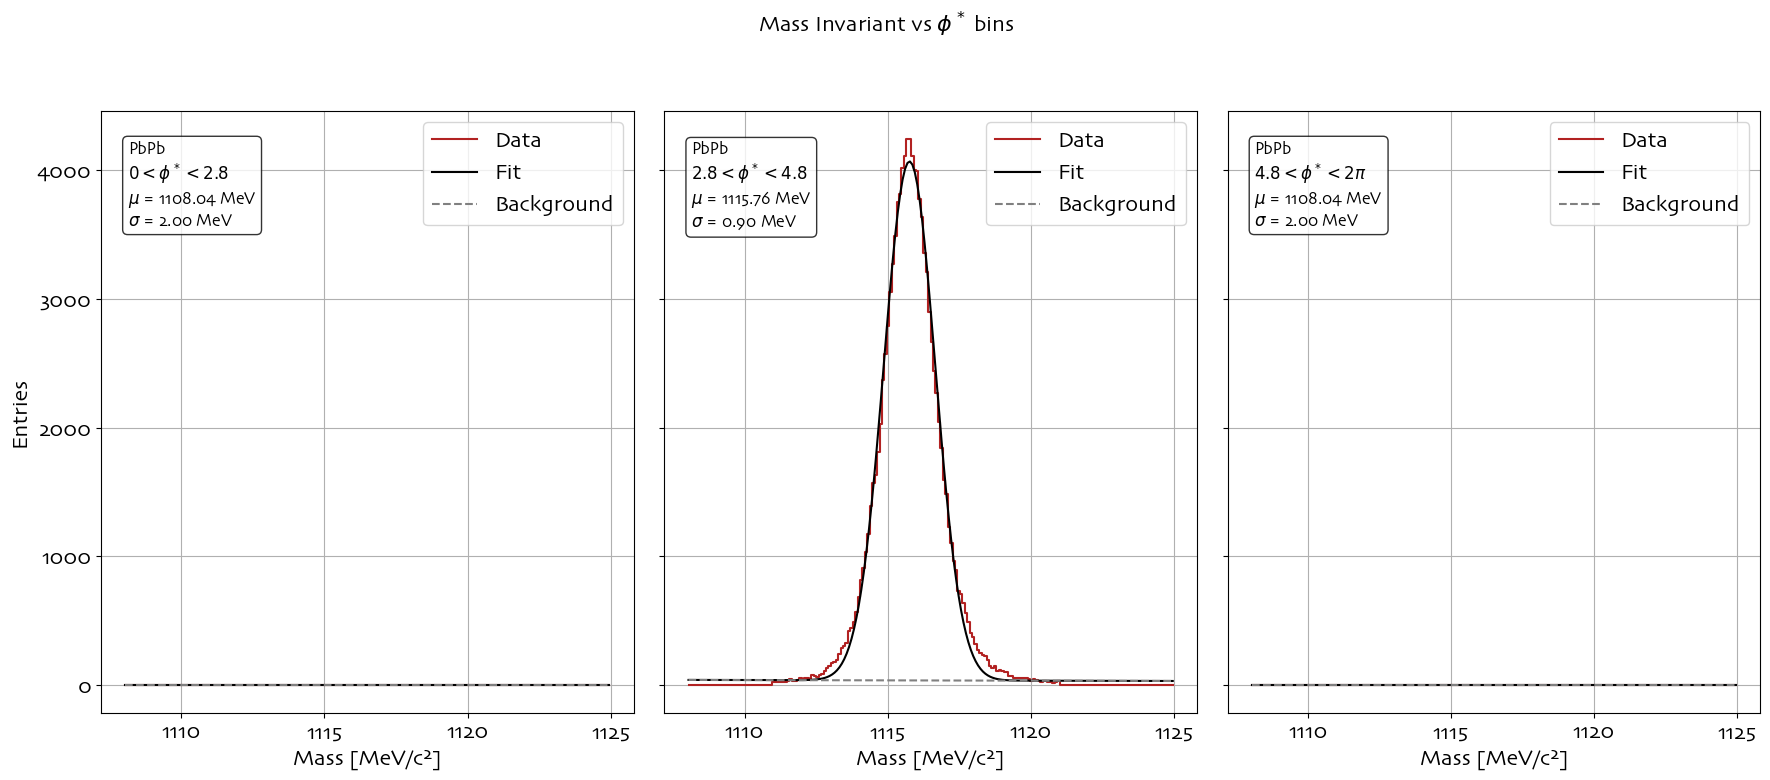

In [75]:
plot_Mass_phi_panels_with_fit(file, base_name="MassInvariant_1_phi", system=system)

Saved panel as PLOTS_ALL/PbPb/PhiStarCosThetaStar_0_cos_theta_star_panel_rebin3.pdf


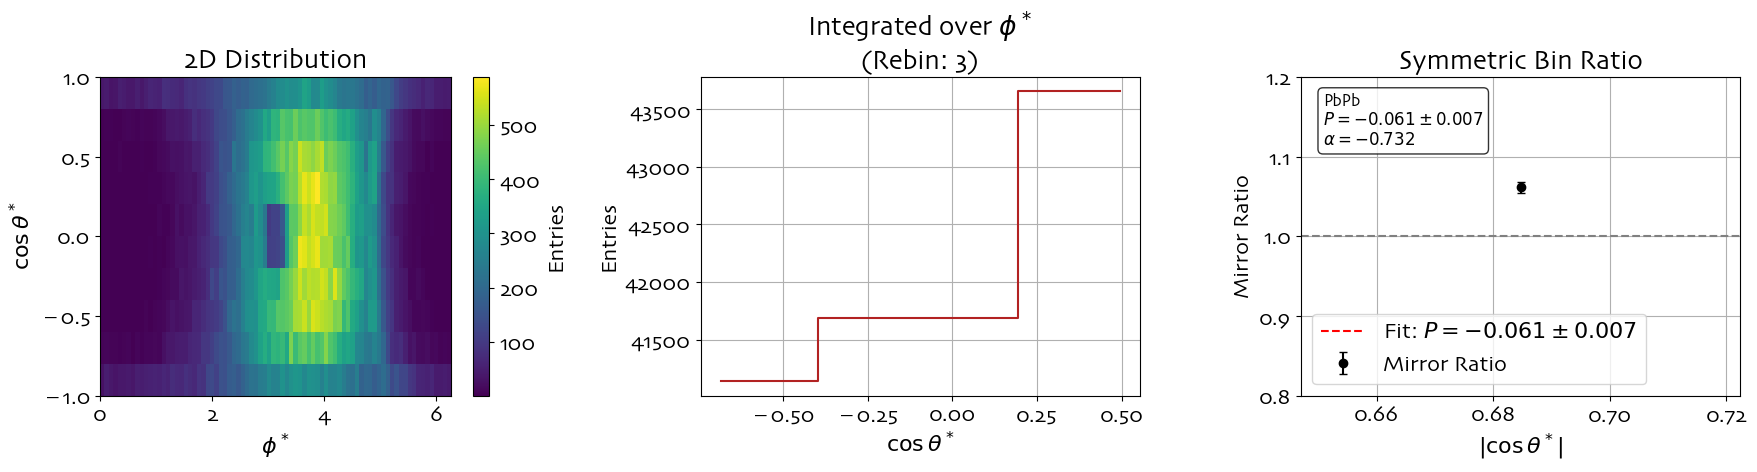

Saved panel as PLOTS_ALL/PbPb/PhiStarCosThetaStar_1_cos_theta_star_panel_rebin3.pdf


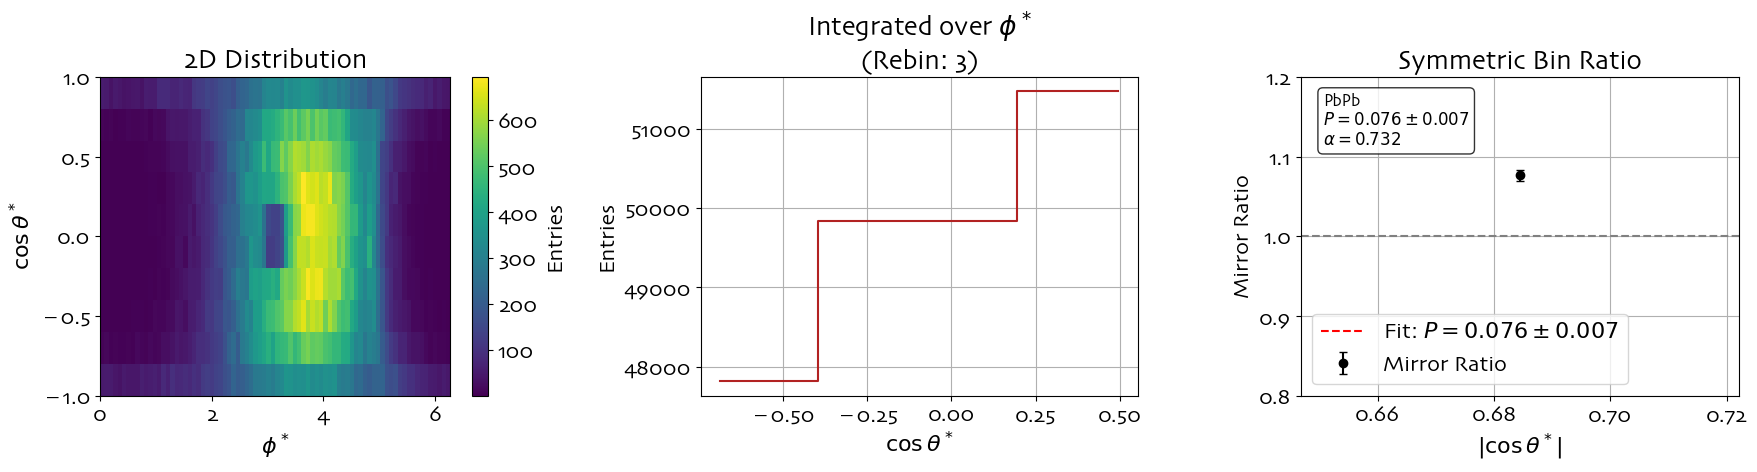

po -0.06105960797035162
p1 0.07617266460662375
Saved comparison plot as PLOTS_ALL/PbPb/Lambda_vs_AntiLambda_ratio_with_fit_rebin3.pdf


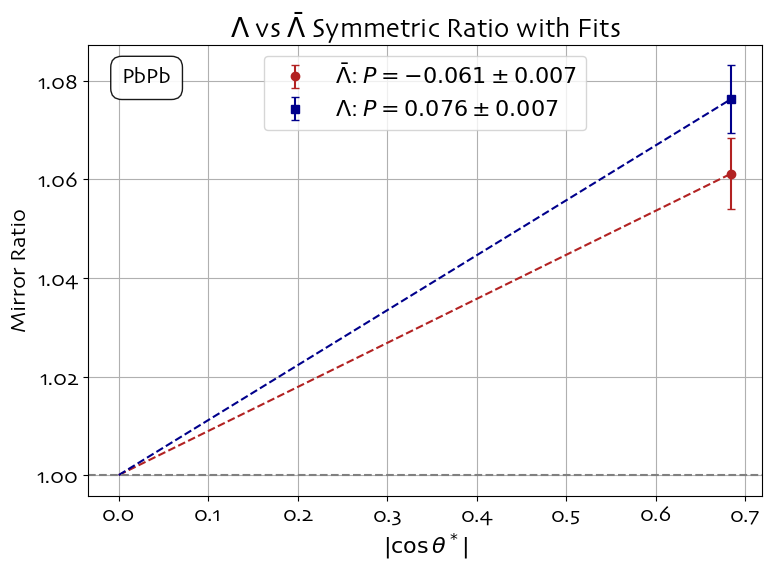

In [76]:
x0, y0, yerr0, P0, P_err0 = plot_cos_theta_star_panel(
    file,
    hist_name="PhiStarCosThetaStar_0",
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    yrange_ratio=(0.8, 1.2),
    anti=0,
)

x1, y1, yerr1, P1, P_err1 = plot_cos_theta_star_panel(
    file,
    hist_name="PhiStarCosThetaStar_1",
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    yrange_ratio=(0.8, 1.2),
    anti=1,
)

compare_cos_theta_star_ratios(
    x0, y0, yerr0, P0, P_err0,
    x1, y1, yerr1, P1, P_err1,
    system=system,
    rebin=rebin_cos_theta,
)

✅ Saved polarization vs phi panel as PLOTS_ALL/PbPb/PhiStarCosThetaStar_0_polarization_vs_phi_rebin3.pdf


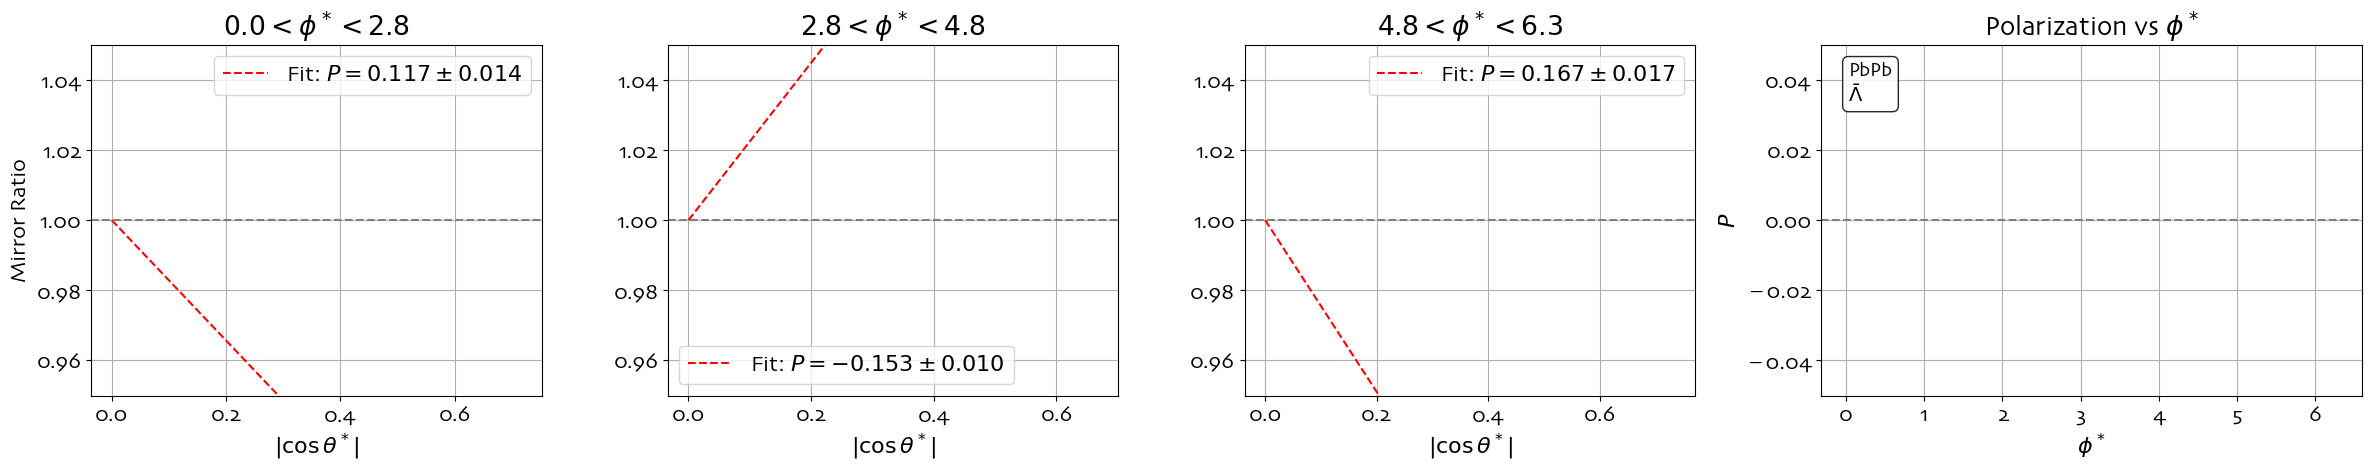

✅ Saved polarization vs phi panel as PLOTS_ALL/PbPb/PhiStarCosThetaStar_1_polarization_vs_phi_rebin3.pdf


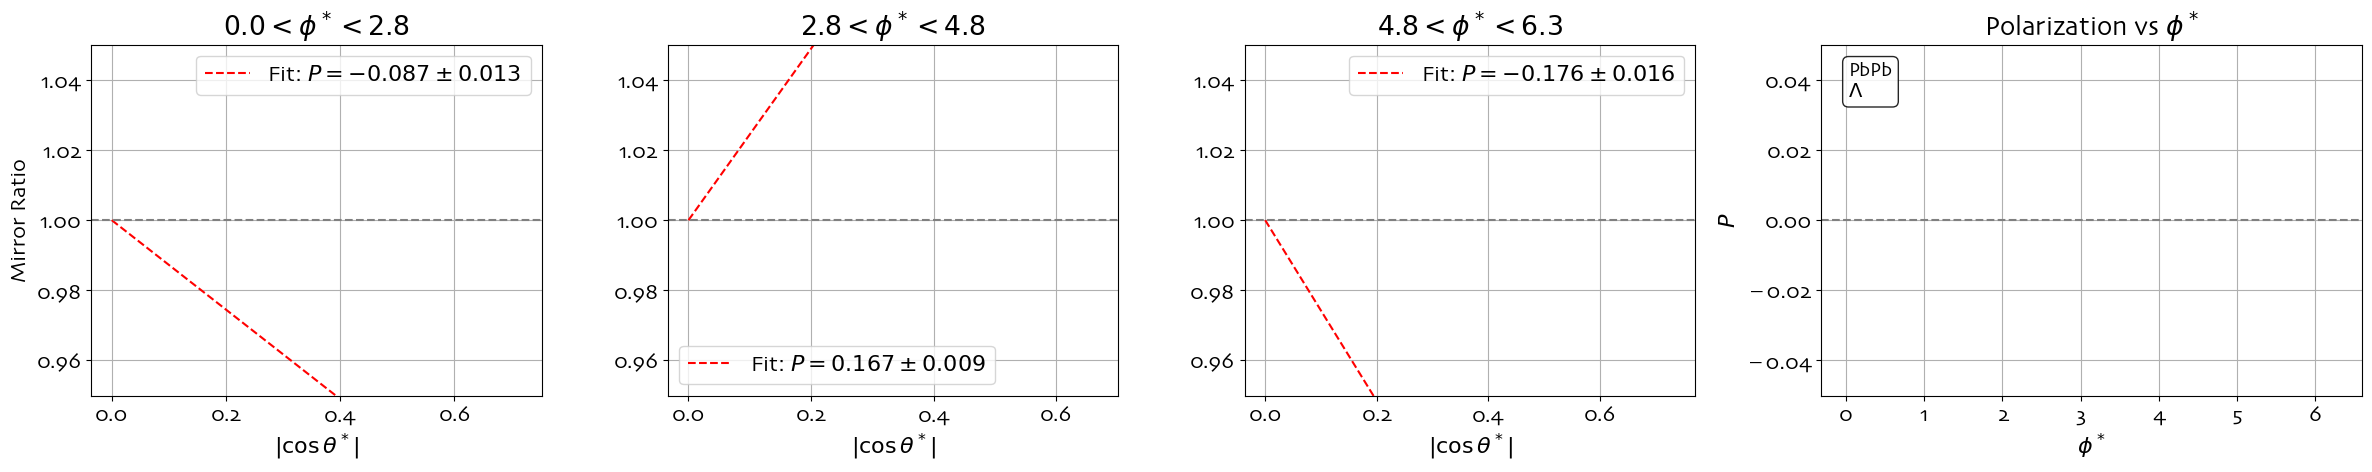

Saved comparison plot as PLOTS_ALL/PbPb/Polarization_vs_phi_comparison.pdf


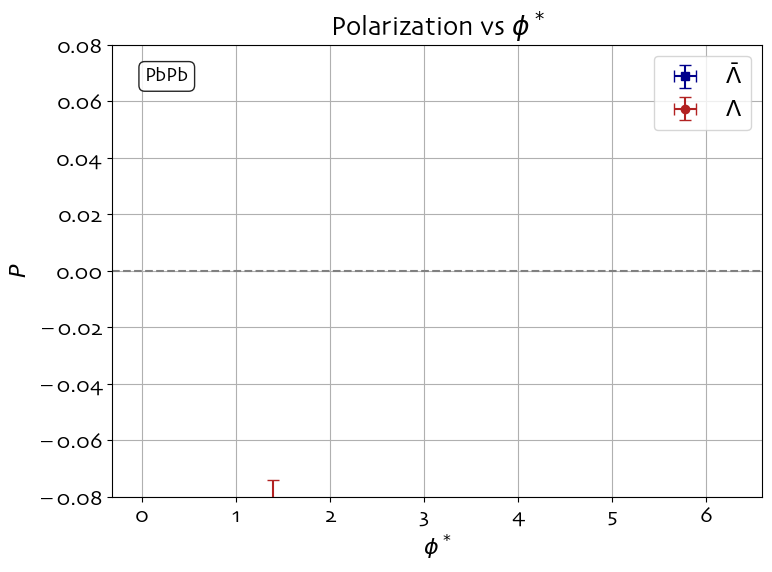

In [77]:
fig0, phi_centers0, P_list0, P_err_list0, phi_widths0 = polarization_ratio_analysis_by_phi(
    file,
    hist_name="PhiStarCosThetaStar_0",
    phi_bins=[0, 2.8, 4.8, 2*np.pi],     # optional (default if None)
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    anti=0,  # 1 for Λ, 0 for anti-Λ
    save=True
)

fig1, phi_centers1, P_list1, P_err_list1, phi_widths1 = polarization_ratio_analysis_by_phi(
    file,
    hist_name="PhiStarCosThetaStar_1", 
    phi_bins=[0, 2.8, 4.8, 2*np.pi],     # optional (default if None)
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    anti=1,  # 1 for Λ, 0 for anti-Λ
    save=True
)



compare_polarization_vs_phi(phi_centers0, P_list0, P_err_list0, phi_widths0,
                             phi_centers1, P_list1, P_err_list1, phi_widths1,
                             system=system)

/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:879: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


✅ Saved polarization vs xF panel as PLOTS_ALL/PbPb/xFCosThetaStar_0_polarization_vs_xF_rebin1.pdf


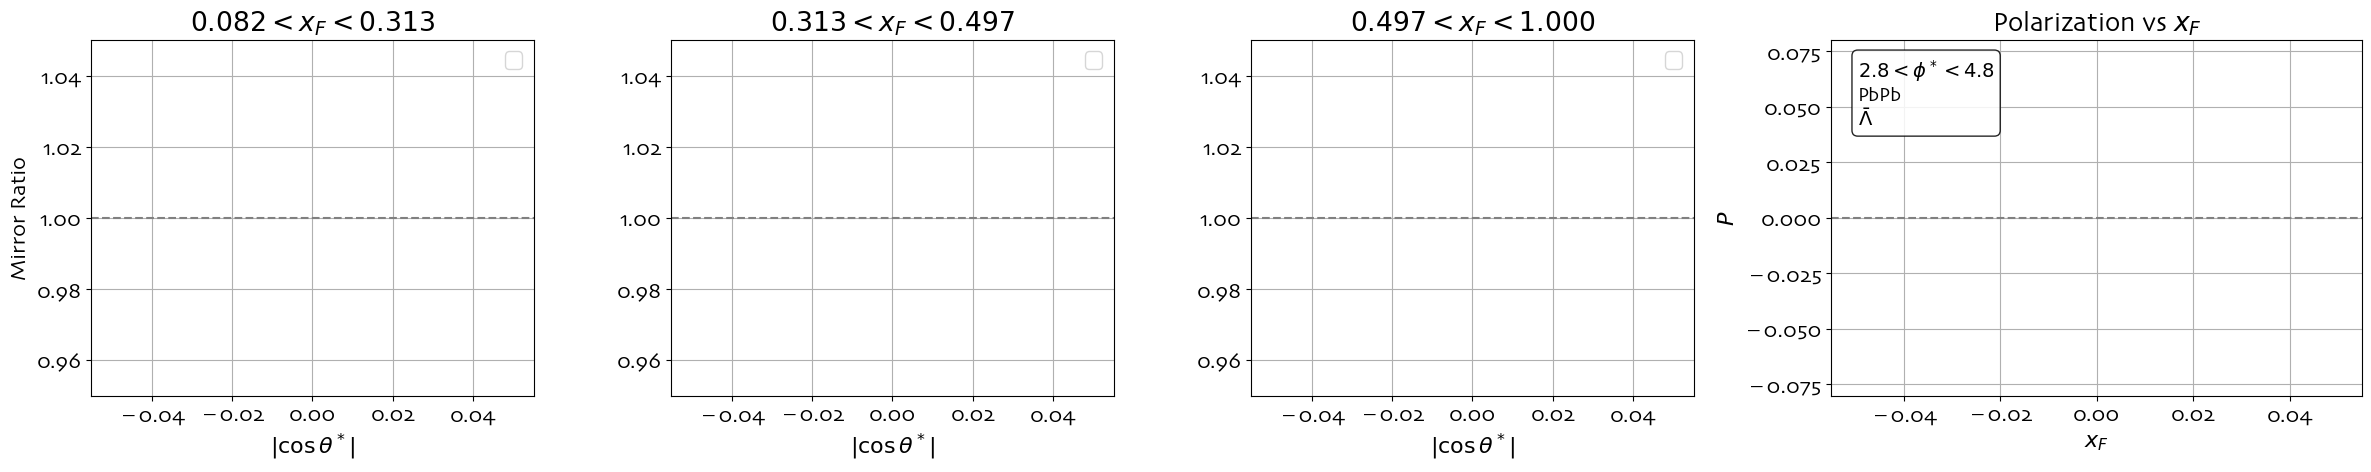

/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:879: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


✅ Saved polarization vs xF panel as PLOTS_ALL/PbPb/xFCosThetaStar_1_polarization_vs_xF_rebin1.pdf


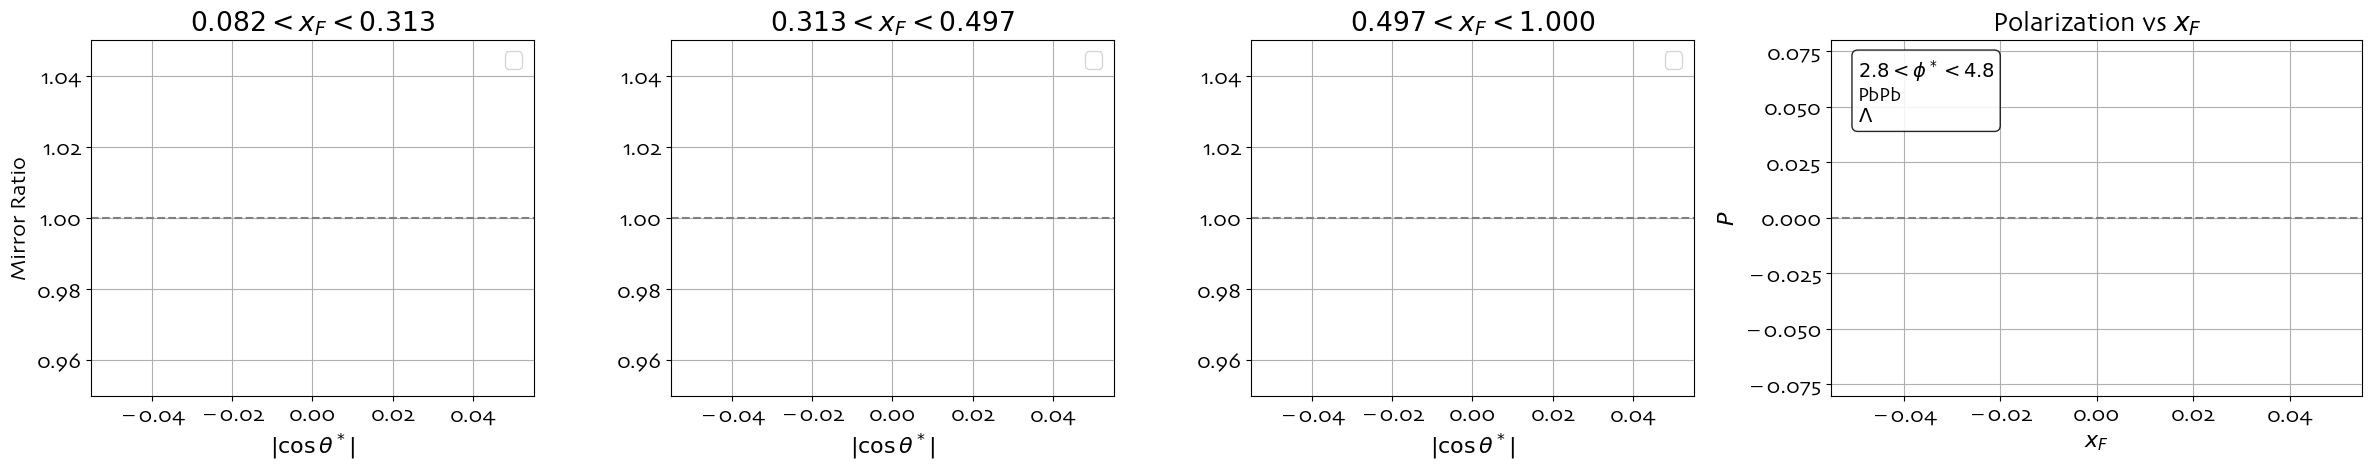

Saved comparison plot as PLOTS_ALL/PbPb/Polarization_vs_xF_comparison.pdf


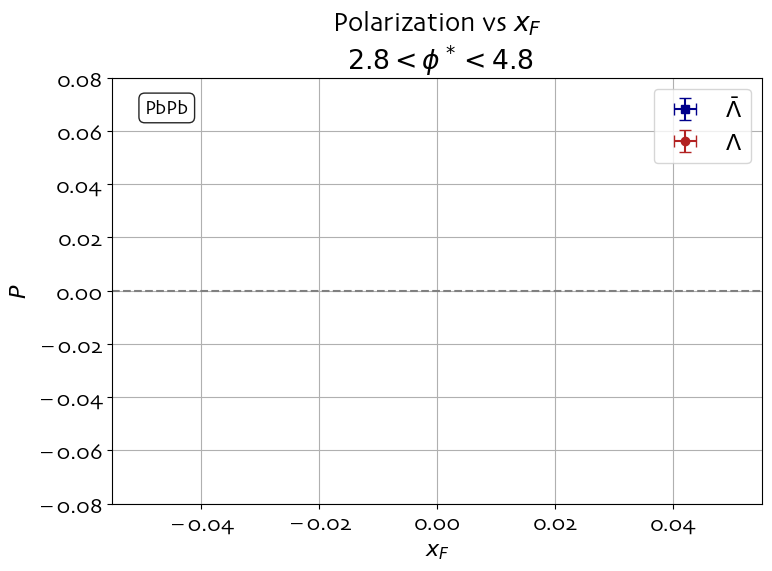

In [78]:

fig0, xf_centers0, P_list0, P_err_list0, xf_widths0 = polarization_ratio_analysis_by_xF(file,  system=system, anti = 0, hist_name='xFCosThetaStar_0', xF_bins=xF_bins)
fig1, xf_centers1, P_list1, P_err_list1, xf_widths1 = polarization_ratio_analysis_by_xF(file,  system=system, anti = 1, hist_name='xFCosThetaStar_1', xF_bins=xF_bins)

compare_polarization_vs_xF(xf_centers0, P_list0, P_err_list0, xf_widths0,
                                xf_centers1, P_list1, P_err_list1, xf_widths1,
                                system=system, save=True)

/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1008: RuntimeWarning: invalid value encountered in divide
  np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_bins]
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1057: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)


✅ Saved large polarization panel as PLOTS_ALL/PbPb/hpTCosThetaStar_0_xf_polarization_pt_xF_grid.pdf


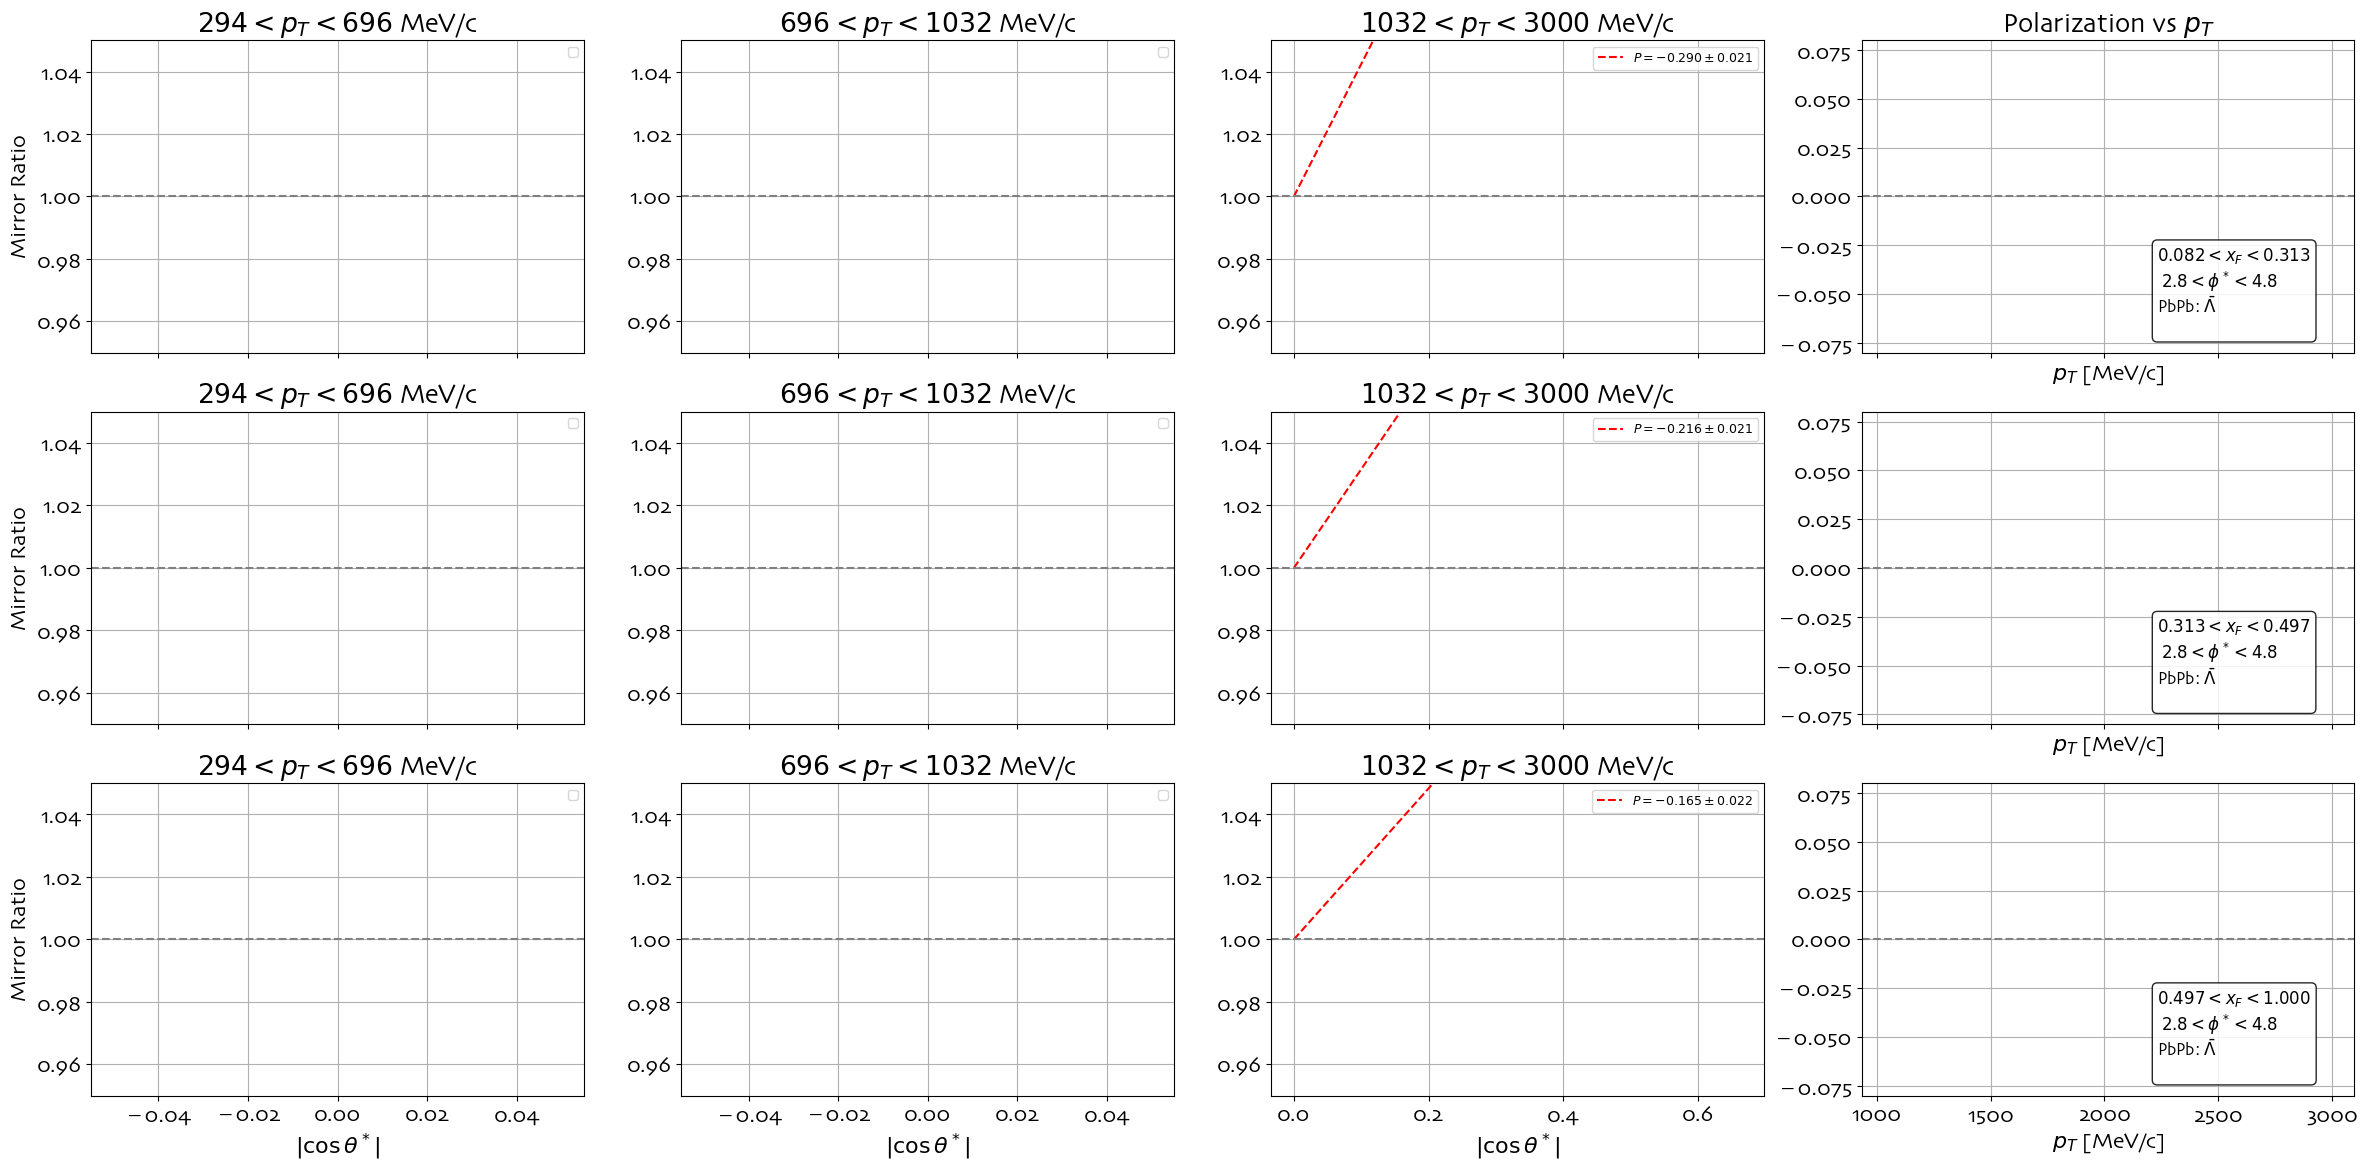

/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1008: RuntimeWarning: invalid value encountered in divide
  np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_bins]
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1057: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)


✅ Saved large polarization panel as PLOTS_ALL/PbPb/hpTCosThetaStar_1_xf_polarization_pt_xF_grid.pdf


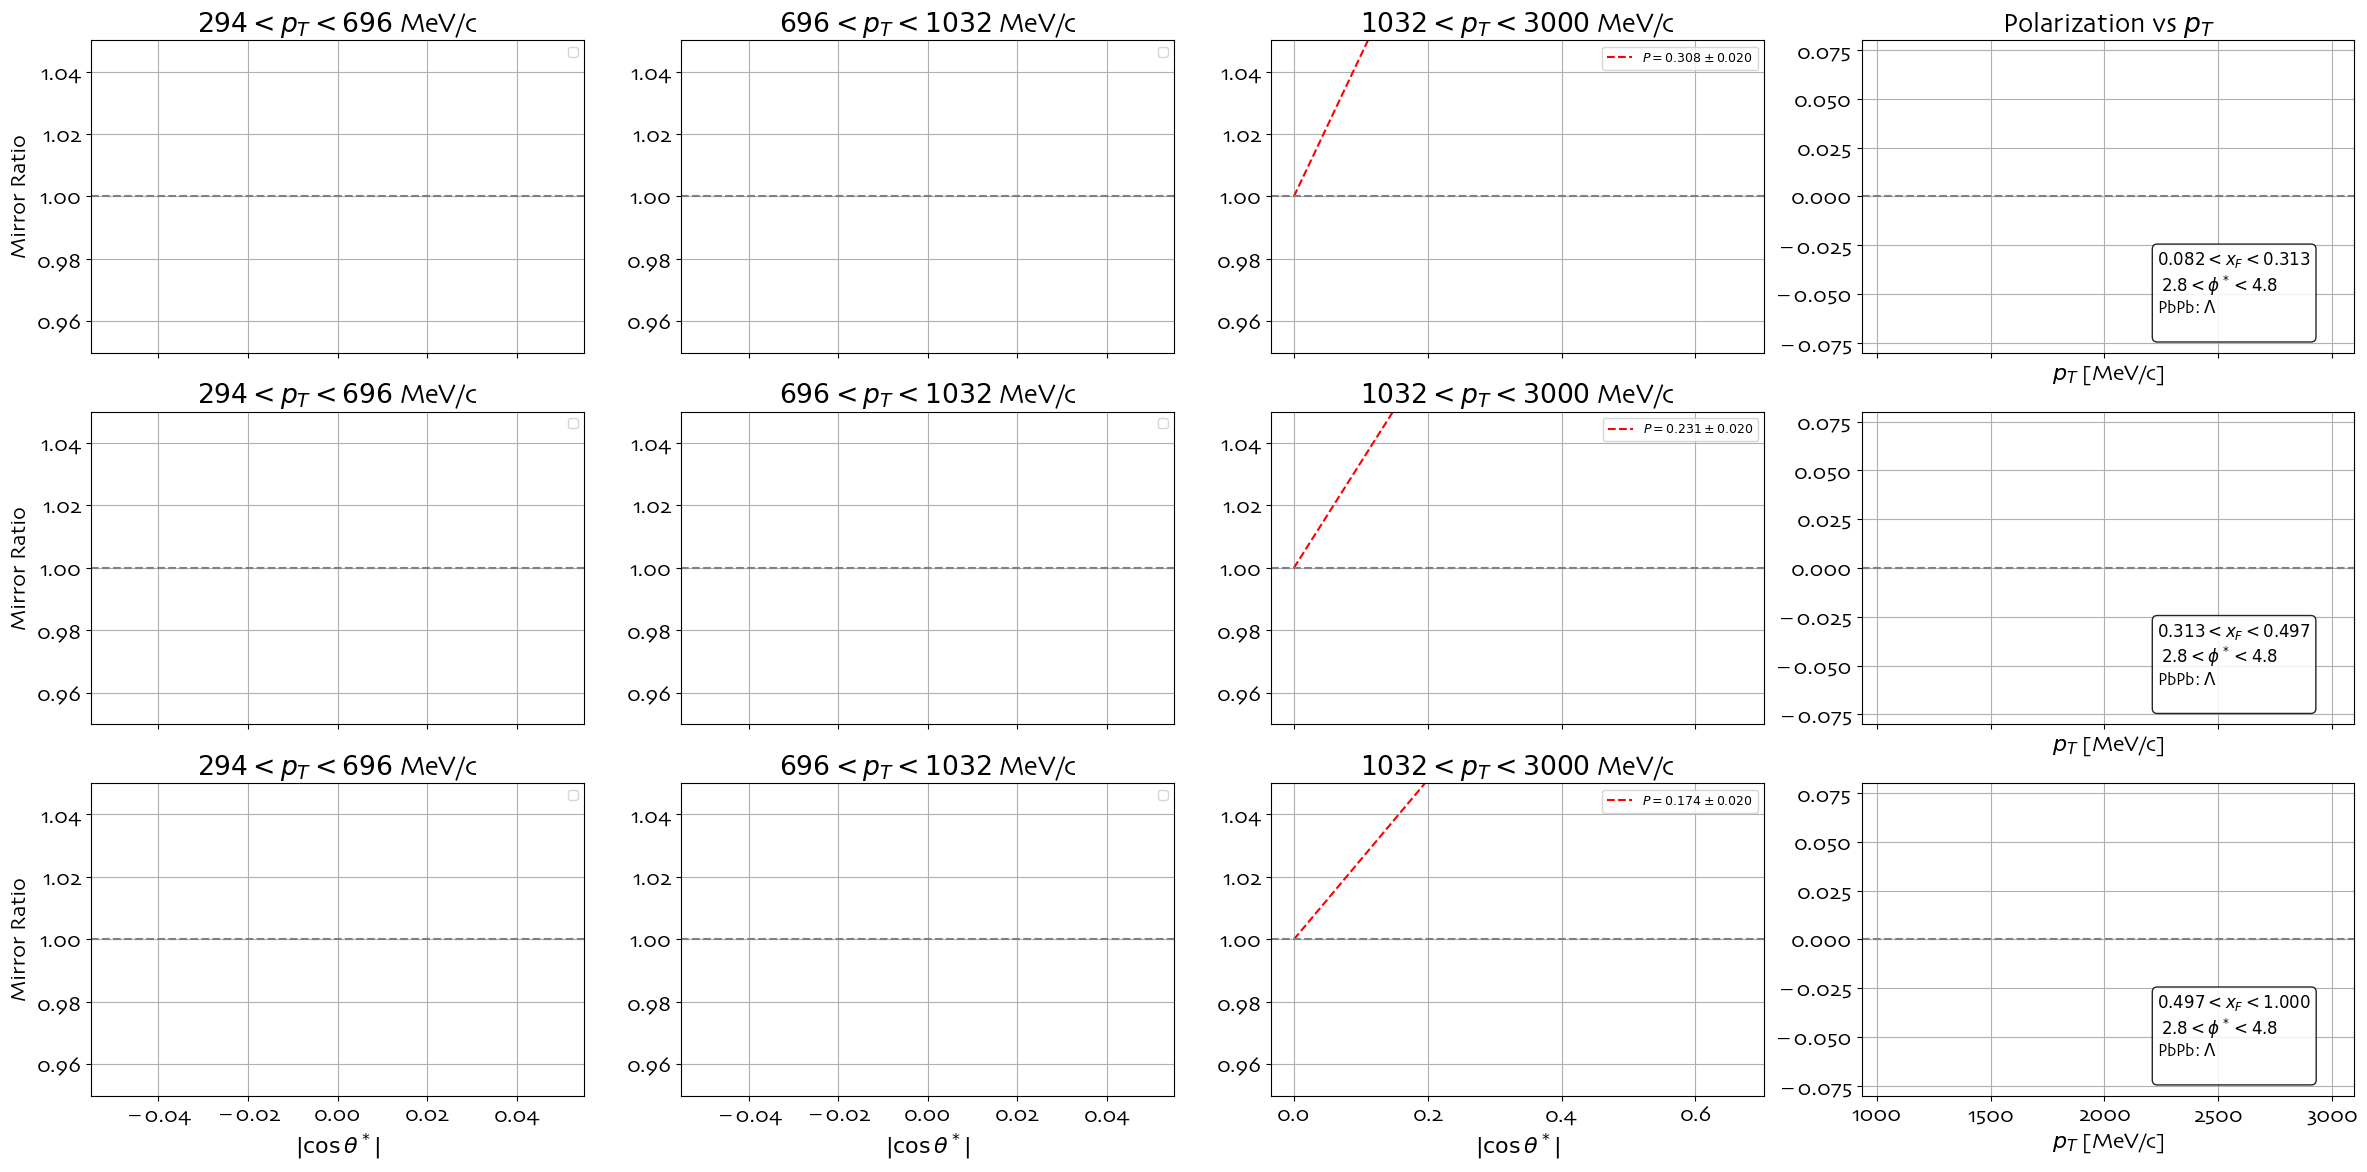

Saved comparison panel as PLOTS_ALL/PbPb/Lambda_vs_AntiLambda_P_vs_pT_panel.pdf


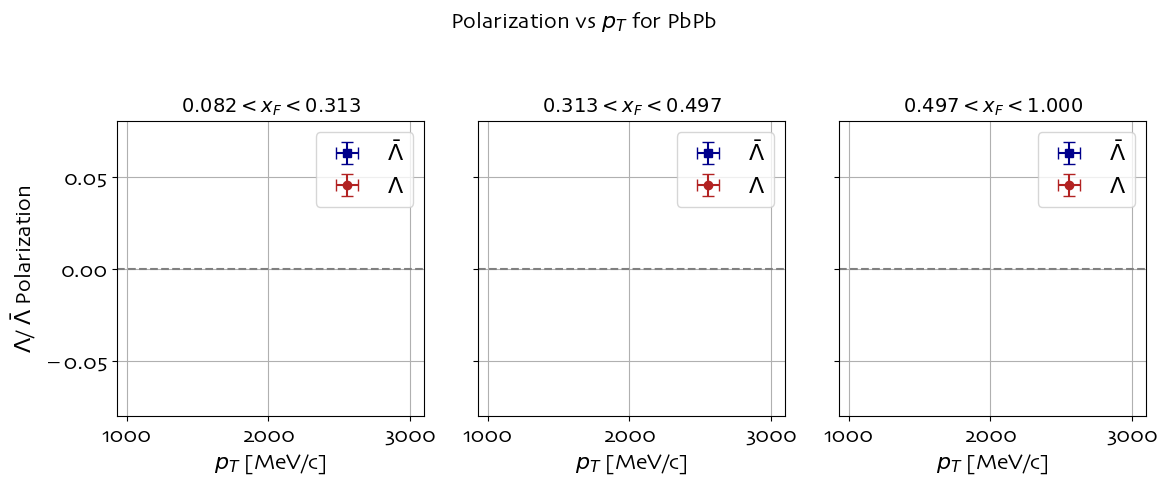

In [79]:
results_aL0 = polarization_ratio_analysis_by_ptxf_grid_updated(
    file,
    hist_prefix="hpTCosThetaStar_0_xf",
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    anti=0,
    yrange_ratio=(0.8, 1.2),
    yrange_polarization=(-0.3, 0.3),
    xF_bins=xF_bins
)

results_aL1 = polarization_ratio_analysis_by_ptxf_grid_updated(
    file,
    hist_prefix="hpTCosThetaStar_1_xf",
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    anti=1,
    yrange_ratio=(0.8, 1.2),
    yrange_polarization=(-0.3, 0.3),
    xF_bins=xF_bins
)
compare_polarization_vs_pt_lambdas(
    results_aL0,
    results_aL1,
    xF_bins=xF_bins,
    system=system,
    save=True,
)


/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1181: RuntimeWarning: invalid value encountered in divide
  np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_bins]
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1228: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)


✅ Saved large polarization panel as PLOTS_ALL/PbPb/hMultiCosThetaStar_0_xf_polarization_multi_xF_grid.pdf


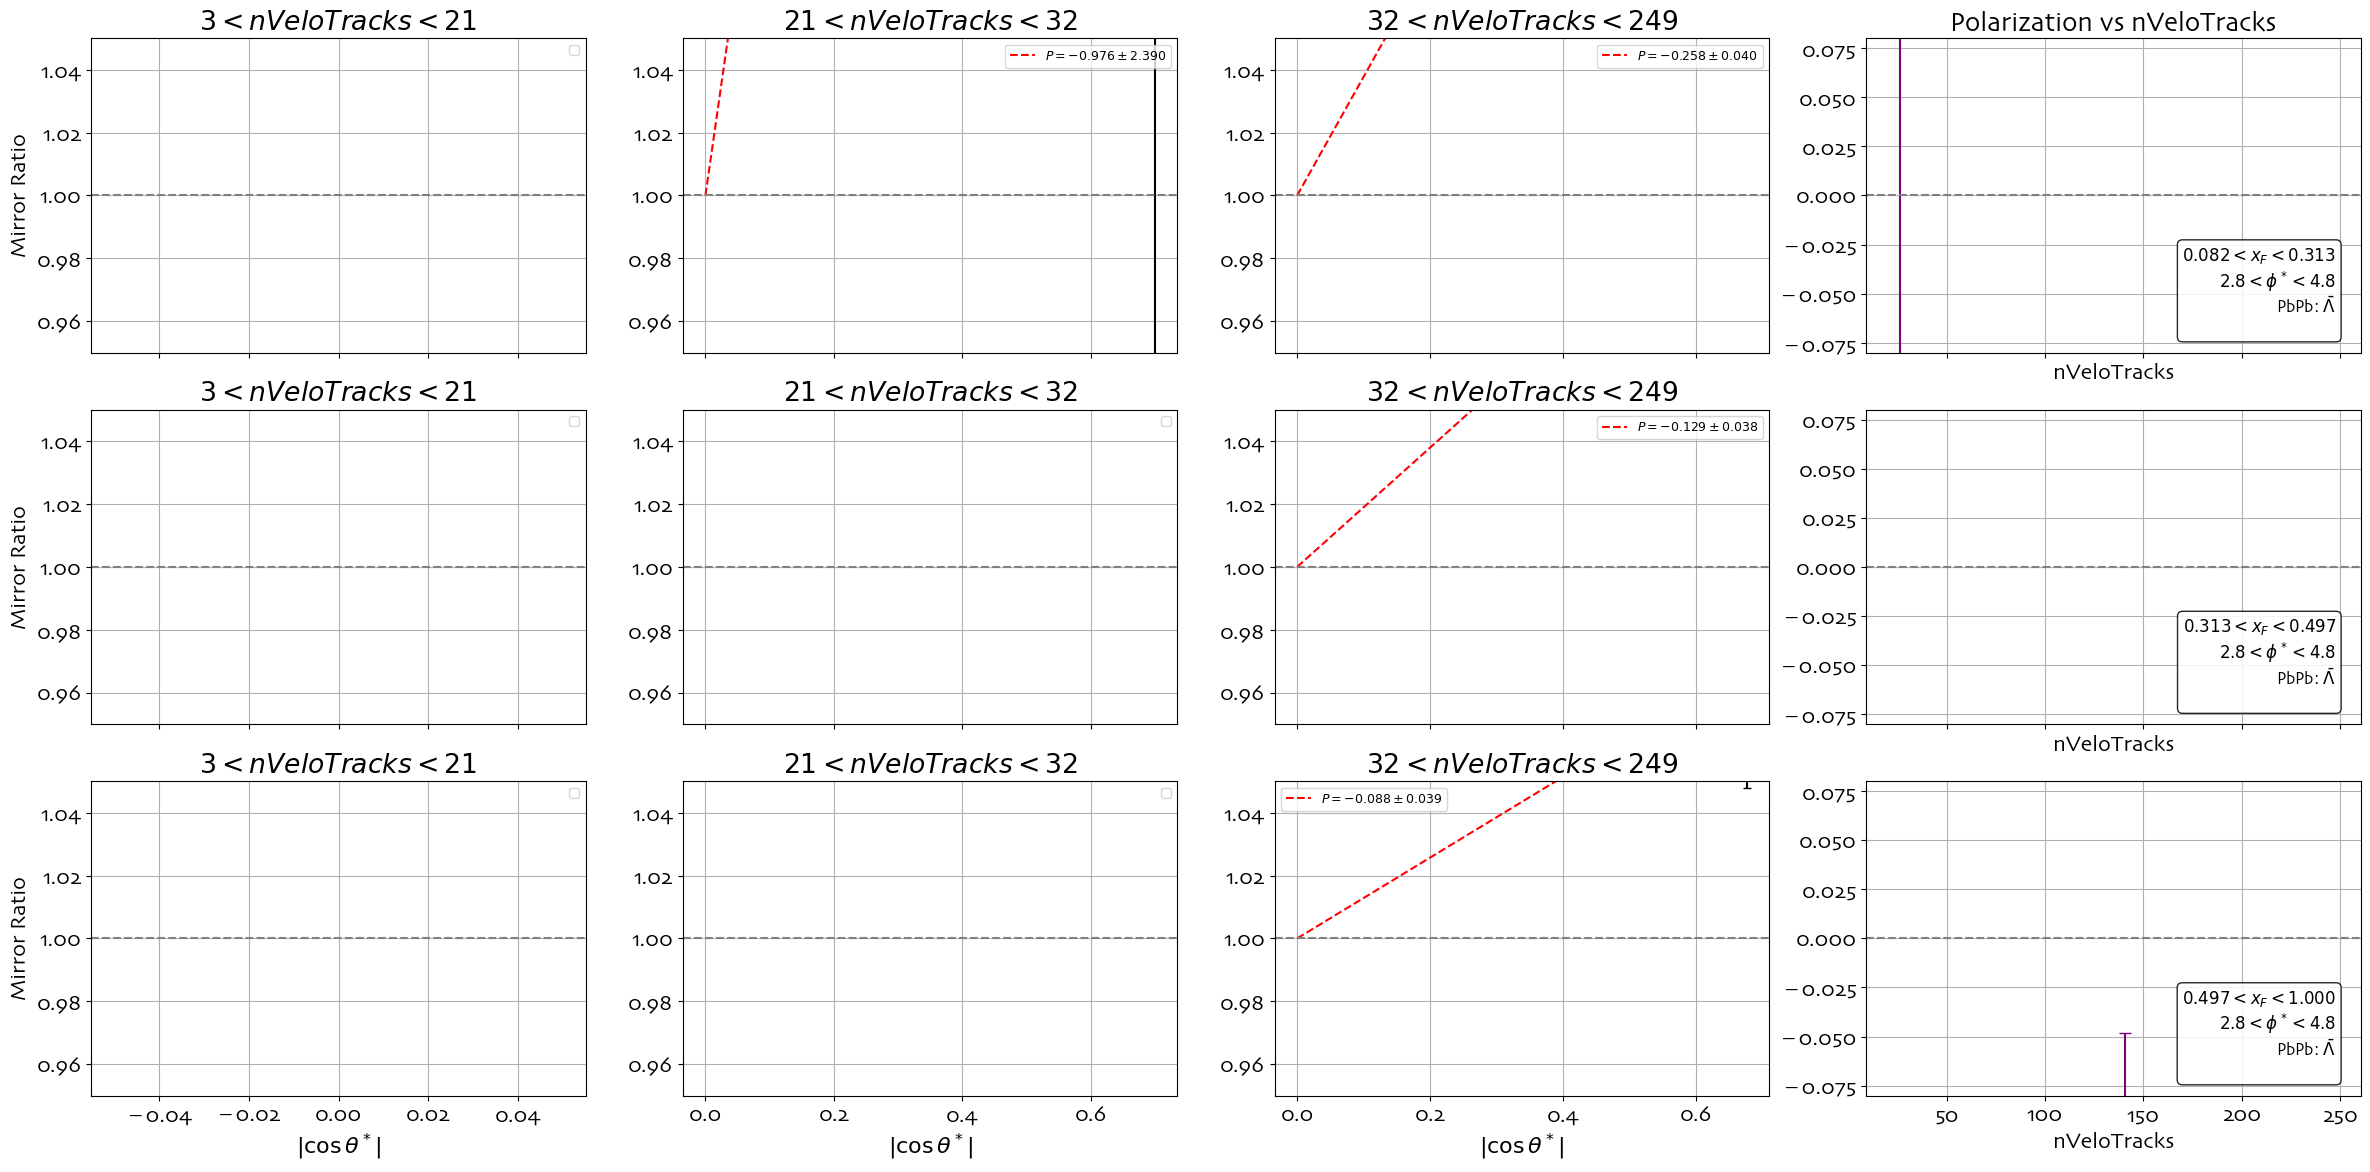

/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1181: RuntimeWarning: invalid value encountered in divide
  np.add.reduceat(weighted_centers, np.arange(0, len(weighted_centers), rebin_cos_theta))[:n_bins]
/var/folders/n_/wmbdlzd17s7gcyvkql_0tn3c0000gq/T/ipykernel_37031/3078162316.py:1228: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=9)


✅ Saved large polarization panel as PLOTS_ALL/PbPb/hMultiCosThetaStar_1_xf_polarization_multi_xF_grid.pdf


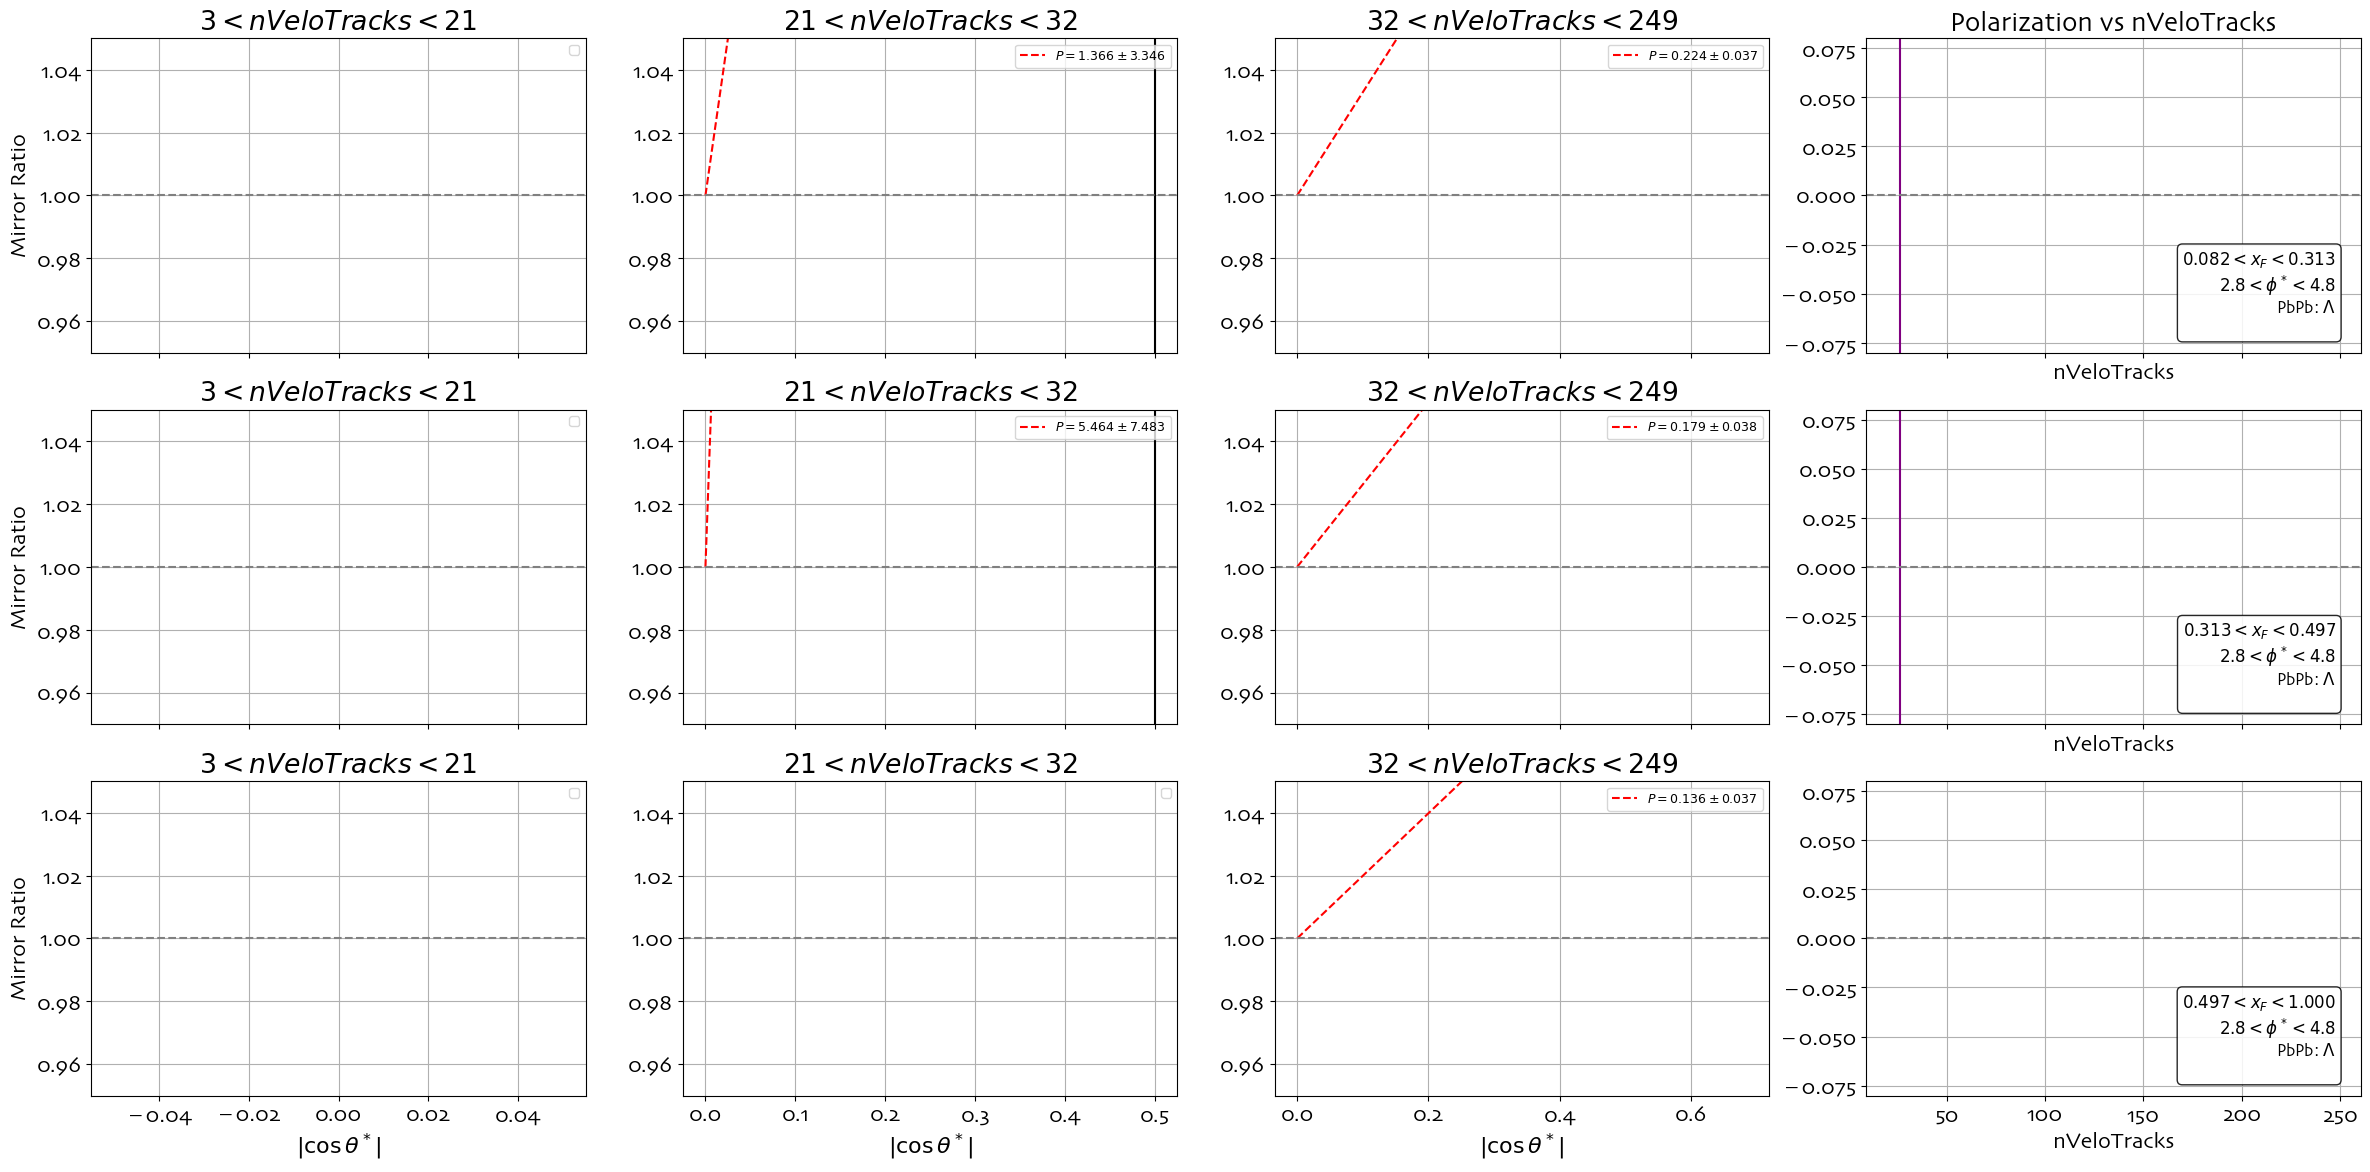

✅ Saved comparison plot as PLOTS_ALL/PbPb/polarization_vs_multi_comparison.pdf


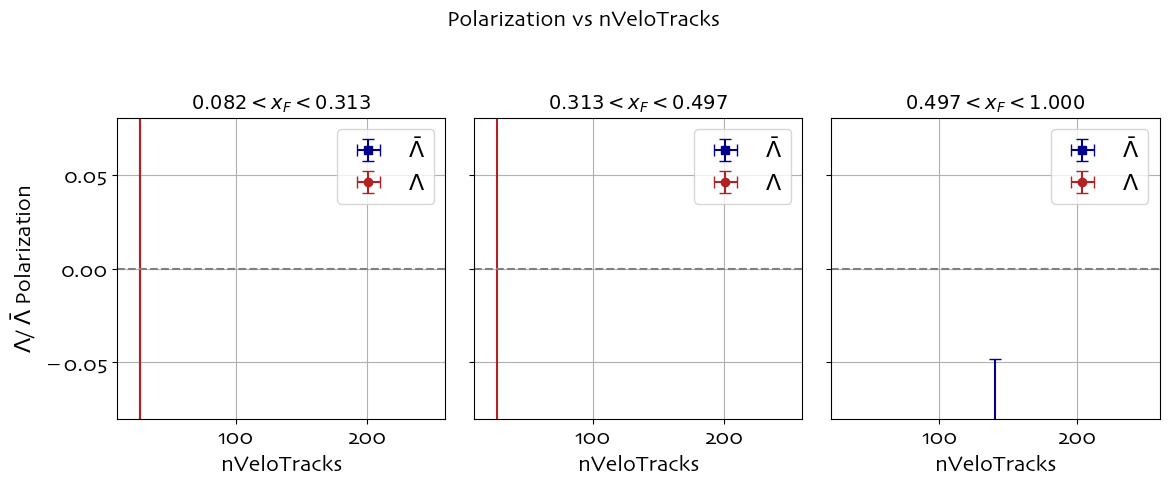

In [80]:
# Run polarization extraction for anti-Lambda and Lambda
P_multi_0 = polarization_ratio_analysis_by_multixf_grid(
    file,
    hist_prefix="hMultiCosThetaStar_0_xf",
    xF_bins=xF_bins,
    multi_bins=nVeloTrack_bins,
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    anti=0,
    save=True
)

P_multi_1  = polarization_ratio_analysis_by_multixf_grid(
    file,
    hist_prefix="hMultiCosThetaStar_1_xf",
    xF_bins=xF_bins,
    multi_bins=nVeloTrack_bins,
    system=system,
    rebin_cos_theta=rebin_cos_theta,
    anti=1,
    save=True
)



compare_polarization_vs_multi_lambdas(P_multi_0, P_multi_1, system=system)

In [66]:
system = 'PbPb'
#Open DATA root file:
pNeRF = getRootFileUproot(system, 0)
file1 = pNeRF #pArRF
#Open MC root file:
pNeMCRF = getRootFileUproot(system, 1)
file2 = pNeMCRF #pArRF



Opening:  /Users/stefaniak.9/Library/CloudStorage/OneDrive-TheOhioStateUniversity/LHCb_Maria/Vorticity/ROOT_files_ready/Polarization_PbPb_data_L0_AL0.root
Opening:  /Users/stefaniak.9/Library/CloudStorage/OneDrive-TheOhioStateUniversity/LHCb_Maria/Vorticity/ROOT_files_ready/Polarization_PbPb_MC_L0_AL0.root


✅ Saved: PLOTS_ALL/MCcorrections/PhiStarCosThetaStar_1_MCcorr.pdf


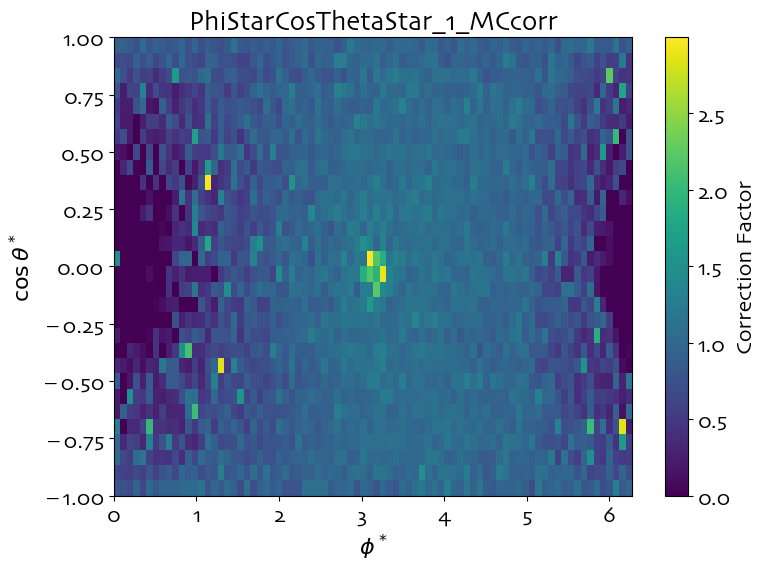

In [67]:
result = divide_normalized_2d_histograms(file1, file2, "PhiStarCosThetaStar_1", "PhiStarCosThetaStar_1")
if result:
    plot_2d_histogram_with_errors(result, save=True, output_folder="PLOTS_ALL/MCcorrections")